# Random Ensemble Orchestration - With get STATE


## RL test

Defining the Simulation enviroment

In [1]:
import logging
import os
import numpy as np

from managers.state_manager import StateManager 
from managers.visualization_manager import VisualizationManager, DashApp
from managers.objective import rl_reward_estimation
from managers.config_manager import ConfigManager



import gym
from gym import spaces


class SimulationEnv(gym.Env):

    def __init__(self):
        super(SimulationEnv, self).__init__()

        current_dir = os.getcwd()   
        

        parent_dir = os.path.dirname(current_dir)
        CONFIG_PATH = os.path.join(current_dir, "sim_config.yaml")
        PROFILE_PATH = os.path.join(current_dir, "profile/model_profile/model_profile.yaml")
        self.CONTRACT_PATH = os.path.join(current_dir, "config/contract_metrics.json")


        self.state_manager = StateManager(current_dir)
        self.config_manager = ConfigManager(PROFILE_PATH, CONFIG_PATH)
        self.visualization_manager = VisualizationManager(current_dir)
        self.dash_app = DashApp(self.visualization_manager)

        self.dash_app.run()

        # Define constants
        self.state_size = self.state_manager.state_lenght # Change this to be dynamic based on the enviroment
        # Observation space: Fixed size of 55
        self.observation_space = spaces.Box(
            low=0.0, high=10.0, shape=(self.state_size,), dtype=np.float32
        )

        # Action space (example: add/remove/replace a model)
        self.action_space = spaces.Discrete(3)

        self.weights = {
            "accuracy": 1.0,
            "confidence": 0.0,
            "latency": 0.0,
            "energy": 0.0,
            "explainability": 0.0
        }

    def reset(self):
        # Reset the environment to an initial state
        # Define Init Data:
        
        self.current_state = self.state_manager.get_state()  # Get initial state
        
        return self.state_manager.flatten_structured_state(self.current_state)

    def step(self, action):
        
        if action == 0:
            self.apply_action("keep_ensemble")
        elif action == 1:
            self.apply_action("add_model")
        elif action == 2:
            self.apply_action("replace_model")
      
        state = self.state_manager.get_state()
        print("STATE: ", state)

        # Simulate a step in the environment
        self.current_state = state
        reward = self._calculate_reward(self.current_state)

        state["reward"] = reward

        self.visualization_manager.reward_list.append(reward)
        self.visualization_manager.add_state_to_csv(state)
        self.dash_app.update_graph()

        print("REWARD: ", reward)

        done = False  # Define termination condition if applicable
        
        return  self.state_manager.flatten_structured_state(self.current_state), reward, done, {}


    def _calculate_reward(self, state):

        # TO REDO
        model_states = state["model_states"]["ensemble"]
        performance_metrics = {}
        performance_metrics["accuracy"] = model_states["accuracy"]
        performance_metrics["confidence"] = model_states["confidence"]
        performance_metrics["explainability"] = 1.0
        performance_metrics["energy"] = state["ensemble_state"]["total_energy_consumption"]
        performance_metrics["latency"] = model_states["avg_response_time"]
 

        
        reward = rl_reward_estimation(performance_metrics, self.CONTRACT_PATH)


        return reward
    
    def apply_action(self, action):
    
        weights = self.weights
        manager = self.config_manager
        if action == "keep_ensemble":
            logging.info("Action: Keeping the ensemble")
        
        elif action == "add_model":
            manager.add_best_model(weights)
            logging.info("Action: Adding a model")
            # Logic for adding a new model (Placeholder)
        elif action == "replace_model":
            logging.info("Action: Replacing a model")
            manager.remove_worst_model(weights)
            manager.add_best_model(weights)
            # Logic for replacing a model (Placeholder)
        elif action == "remove_model":
            manager.remove_worst_model(weights)

        elif action == "add_random_model":
            manager.add_random_model()
        elif action == "remove_random_model":
            manager.remove_random_model()
        elif action == "replace_random_model":
            manager.remove_random_model()
            manager.add_random_model()


        else:
            logging.warning("Unknown action")

Running the simulation

In [2]:
from stable_baselines3 import PPO

#setup_config()

# Create the environment
env = SimulationEnv()

# Train the agent
model = PPO("MlpPolicy", env, verbose=1, n_steps=1028)
model.learn(total_timesteps=1)

# Save the trained model
model.save("simulation_policy")


Contents of c:\Documents\Aalto Semester 2\ResearchCloud\RL_simulation\initial_sim_config.yaml have been dumped into c:\Documents\Aalto Semester 2\ResearchCloud\RL_simulation\sim_config.yaml.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\Filippo\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.

c:\Users\Filippo\anaconda3\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning:

You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1028`, after every 16 untruncated mini-batches, there will be a truncated mini-batch of size 4
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1028 and n_envs=1)

2025-01-28 15:52:21,761:INFO -- Action: Adding a model


Best model: EfficientNetV2S with score: 0.953925925925926
Model 'EfficientNetV2S' successfully added to the target YAML.
STATE:  {'ensemble_state': {'total_energy_consumption': 0.003833157044692698, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.5262173612912496, 'avg_response_time': 2.084688843683192, 'max_response_time': 2.144495518235469, 'contribution': 0.2994645635286967}, 'MobileNetV2': {'accuracy': 0.3333333333333333, 'confidence': 0.29443474610646564, 'avg_response_time': 0.03163960823469955, 'max_response_time': 0.038629286375490984, 'contribution': 0.29443474610646564}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.3332943518956502, 'avg_response_time': 0.11916933314687535, 'max_response_time': 0.12852528502682153, 'contribution': 0.6088864008585612}, 'ensemble': {'accuracy': 0.6666666666666666, 'confidence': 0.5962646868493823, 'avg_response_time': 2.0951593731502722, 'max_response_time': 2.1538846

2025-01-28 15:52:23,075:INFO -- Action: Adding a model


REWARD:  3.9799673915208267
Best model: NASNetLarge with score: 0.942962962962963
Model 'NASNetLarge' successfully added to the target YAML.


2025-01-28 15:52:23,334:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.006996982659451798, 'ensemble_size': 5}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.75, 'confidence': 0.6248959898948669, 'avg_response_time': 2.071759220683632, 'max_response_time': 2.144495518235469, 'contribution': 0.45483139157295227}, 'MobileNetV2': {'accuracy': 0.5, 'confidence': 0.4404422789812088, 'avg_response_time': 0.027577185996276125, 'max_response_time': 0.038629286375490984, 'contribution': 0.4404422789812088}, 'ResNet50V2': {'accuracy': 0.5, 'confidence': 0.3517714738845825, 'avg_response_time': 0.1179578448175417, 'max_response_time': 0.12852528502682153, 'contribution': 0.5584655106067657}, 'ensemble': {'accuracy': 0.75, 'confidence': 0.6497036983569464, 'avg_response_time': 2.531350378219589, 'max_response_time': 3.8399233934275396, 'contribution': 0.9031233638525009}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.8904353082180023, 'avg_response_time': 1.138849439115788, 'max_response_time': 1

2025-01-28 15:52:23,574:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.006996982659451798, 'ensemble_size': 5}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8, 'confidence': 0.6857612013816834, 'avg_response_time': 2.0642710968197227, 'max_response_time': 2.144495518235469, 'contribution': 0.5497095227241516}, 'MobileNetV2': {'accuracy': 0.6, 'confidence': 0.5403431057929993, 'avg_response_time': 0.02971681304500053, 'max_response_time': 0.038629286375490984, 'contribution': 0.5403431057929993}, 'ResNet50V2': {'accuracy': 0.6, 'confidence': 0.47564694881439207, 'avg_response_time': 0.11742181422001033, 'max_response_time': 0.12852528502682153, 'contribution': 0.6410021781921387}, 'ensemble': {'accuracy': 0.8, 'confidence': 0.7067159907023113, 'avg_response_time': 2.784744975228457, 'max_response_time': 3.8399233934275396, 'contribution': 0.9167284607887268}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9043493866920471, 'avg_response_time': 1.1434418348946593, 'max_response_time': 1

2025-01-28 15:52:23,911:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.006996982659451798, 'ensemble_size': 5}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.7282340427239736, 'avg_response_time': 2.065887940642281, 'max_response_time': 2.144495518235469, 'contribution': 0.6148576438426971}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.5038270503282547, 'avg_response_time': 0.03223899603243439, 'max_response_time': 0.04484991096960366, 'contribution': 0.5038270503282547}, 'ResNet50V2': {'accuracy': 0.5, 'confidence': 0.3963724573453267, 'avg_response_time': 0.11804588517545968, 'max_response_time': 0.12852528502682153, 'contribution': 0.5341684818267822}, 'ensemble': {'accuracy': 0.8333333333333334, 'confidence': 0.7099189088576371, 'avg_response_time': 2.9598943830819953, 'max_response_time': 3.8399233934275396, 'contribution': 0.9207067588965098}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9108916521072388, 'avg_response_time':

2025-01-28 15:52:24,213:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.011539725062961177, 'ensemble_size': 6}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.7532832026481628, 'avg_response_time': 2.0730289727327773, 'max_response_time': 2.144495518235469, 'contribution': 0.6561034321784973}, 'MobileNetV2': {'accuracy': 0.7142857142857143, 'confidence': 0.5658079428332192, 'avg_response_time': 0.03288209775141878, 'max_response_time': 0.04484991096960366, 'contribution': 0.5658079428332192}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.8571428571428571, 'confidence': 0.7385479162846293, 'avg_response_time': 3.552253749681167, 'max_response_time': 7.1064099492761965, 'contribution': 0.9320322700909206}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9137818574905395, 'avg_r

2025-01-28 15:52:24,663:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.011354318386132727, 'ensemble_size': 6}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.875, 'confidence': 0.7724207639694214, 'avg_response_time': 2.0776366122271366, 'max_response_time': 2.144495518235469, 'contribution': 0.687388464808464}, 'MobileNetV2': {'accuracy': 0.75, 'confidence': 0.6155490539968014, 'avg_response_time': 0.0337710607365712, 'max_response_time': 0.04484991096960366, 'contribution': 0.6155490539968014}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.875, 'confidence': 0.75806691814214, 'avg_response_time': 3.992528851277204, 'max_response_time': 7.1064099492761965, 'contribution': 0.9397020116448402}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9116517702738444, 'avg_response_time': 1.1584358572844184, 'max_resp

2025-01-28 15:52:25,060:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.011354318386132727, 'ensemble_size': 6}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.7887648079130385, 'avg_response_time': 2.0764119228607387, 'max_response_time': 2.144495518235469, 'contribution': 0.7131805419921875}, 'MobileNetV2': {'accuracy': 0.7777777777777778, 'confidence': 0.6529386407799191, 'avg_response_time': 0.04192996017132648, 'max_response_time': 0.10720115564936877, 'contribution': 0.6529386407799191}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.8888888888888888, 'confidence': 0.7763680733464383, 'avg_response_time': 4.339736094305094, 'max_response_time': 7.1173940385282135, 'contribution': 0.9463804562886556}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.916156530380249, 'avg_re

2025-01-28 15:52:25,392:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.016839173459921662, 'ensemble_size': 7}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8, 'confidence': 0.7098883271217347, 'avg_response_time': 2.072370006984685, 'max_response_time': 2.144495518235469, 'contribution': 0.6418624877929687}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.6746802538633346, 'avg_response_time': 0.041882615563376926, 'max_response_time': 0.10720115564936877, 'contribution': 0.6746802538633346}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.9, 'confidence': 0.7835632806519668, 'avg_response_time': 4.6214898055406834, 'max_response_time': 7.157273206660992, 'contribution': 0.9400223791599274}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9105604588985443, 'avg_response_time': 1.1535019387008025, 'max_respo

2025-01-28 15:52:25,768:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.016839173459921662, 'ensemble_size': 7}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8181818181818182, 'confidence': 0.7298655347390608, 'avg_response_time': 2.0718441781477313, 'max_response_time': 2.144495518235469, 'contribution': 0.668023862622001}, 'MobileNetV2': {'accuracy': 0.8181818181818182, 'confidence': 0.686980889602141, 'avg_response_time': 0.04293592684982646, 'max_response_time': 0.10720115564936877, 'contribution': 0.686980889602141}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.9090909090909091, 'confidence': 0.7913071363325759, 'avg_response_time': 4.852818042916341, 'max_response_time': 7.166100416672916, 'contribution': 0.9412245967171409}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9088950024710761, 'avg_respo

2025-01-28 15:52:26,263:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017675754738927185, 'ensemble_size': 7}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.7472291141748428, 'avg_response_time': 2.069762769217387, 'max_response_time': 2.144495518235469, 'contribution': 0.6905409147342046}, 'MobileNetV2': {'accuracy': 0.8181818181818182, 'confidence': 0.686980889602141, 'avg_response_time': 0.04293592684982646, 'max_response_time': 0.10720115564936877, 'contribution': 0.686980889602141}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.9166666666666666, 'confidence': 0.7977892661674155, 'avg_response_time': 5.043376348022365, 'max_response_time': 7.166100416672916, 'contribution': 0.9456780354181925}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9068763315677643, 'avg_respo

2025-01-28 15:52:26,746:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017675754738927185, 'ensemble_size': 7}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8461538461538461, 'confidence': 0.7625040962145879, 'avg_response_time': 2.0651280030765378, 'max_response_time': 2.144495518235469, 'contribution': 0.7101765275001526}, 'MobileNetV2': {'accuracy': 0.8181818181818182, 'confidence': 0.686980889602141, 'avg_response_time': 0.04293592684982646, 'max_response_time': 0.10720115564936877, 'contribution': 0.686980889602141}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.9230769230769231, 'confidence': 0.8082677051534147, 'avg_response_time': 5.2036589090442895, 'max_response_time': 7.166100416672916, 'contribution': 0.9492710920480582}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9096235199408098, 'avg_res

2025-01-28 15:52:27,393:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017675754738927185, 'ensemble_size': 7}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.7728983802454812, 'avg_response_time': 2.0703769108196526, 'max_response_time': 2.144495518235469, 'contribution': 0.7243084950106484}, 'MobileNetV2': {'accuracy': 0.8181818181818182, 'confidence': 0.686980889602141, 'avg_response_time': 0.04293592684982646, 'max_response_time': 0.10720115564936877, 'contribution': 0.686980889602141}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.9285714285714286, 'confidence': 0.8123963941370144, 'avg_response_time': 5.341656965395383, 'max_response_time': 7.166100416672916, 'contribution': 0.950134881905147}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9105264196793238, 'avg_respo

2025-01-28 15:52:27,981:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017675754738927185, 'ensemble_size': 7}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8666666666666667, 'confidence': 0.7840776403745016, 'avg_response_time': 2.0747869030326282, 'max_response_time': 2.144495518235469, 'contribution': 0.738727080821991}, 'MobileNetV2': {'accuracy': 0.8181818181818182, 'confidence': 0.686980889602141, 'avg_response_time': 0.04293592684982646, 'max_response_time': 0.10720115564936877, 'contribution': 0.686980889602141}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.9333333333333333, 'confidence': 0.820683328107236, 'avg_response_time': 5.460878835041452, 'max_response_time': 7.166100416672916, 'contribution': 0.9534359852472941}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9106144079795251, 'avg_respon

2025-01-28 15:52:28,461:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017825260597325844, 'ensemble_size': 8}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.875, 'confidence': 0.7929595708847046, 'avg_response_time': 2.074163036568352, 'max_response_time': 2.144495518235469, 'contribution': 0.7504434213042259}, 'MobileNetV2': {'accuracy': 0.8181818181818182, 'confidence': 0.686980889602141, 'avg_response_time': 0.04293592684982646, 'max_response_time': 0.10720115564936877, 'contribution': 0.686980889602141}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.9375, 'confidence': 0.8257471814707277, 'avg_response_time': 5.56449430289176, 'max_response_time': 7.166100416672916, 'contribution': 0.9556955173611641}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9107038123267037, 'avg_response_time': 1.1536054649228

2025-01-28 15:52:29,028:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017859681623383035, 'ensemble_size': 9}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8823529411764706, 'confidence': 0.8016131274840411, 'avg_response_time': 2.071560531807325, 'max_response_time': 2.144495518235469, 'contribution': 0.7615979278788847}, 'MobileNetV2': {'accuracy': 0.8181818181818182, 'confidence': 0.686980889602141, 'avg_response_time': 0.04293592684982646, 'max_response_time': 0.10720115564936877, 'contribution': 0.686980889602141}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.9411764705882353, 'confidence': 0.8298434170201268, 'avg_response_time': 5.656220670136061, 'max_response_time': 7.166100416672916, 'contribution': 0.9578674996600431}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9091284354527791, 'avg_respo

2025-01-28 15:52:29,485:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018470515036970083, 'ensemble_size': 10}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.8099540637599097, 'avg_response_time': 2.0709284868966673, 'max_response_time': 2.144495518235469, 'contribution': 0.7721619307994843}, 'MobileNetV2': {'accuracy': 0.8181818181818182, 'confidence': 0.686980889602141, 'avg_response_time': 0.04293592684982646, 'max_response_time': 0.10720115564936877, 'contribution': 0.686980889602141}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.9444444444444444, 'confidence': 0.834807793221829, 'avg_response_time': 5.740772555948342, 'max_response_time': 7.1781546147571245, 'contribution': 0.9601248866981931}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9087997488677502, 'avg_res

2025-01-28 15:52:30,028:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018470515036970083, 'ensemble_size': 10}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8947368421052632, 'confidence': 0.8158338603220487, 'avg_response_time': 2.0693542103469547, 'max_response_time': 2.144495518235469, 'contribution': 0.7800307869911194}, 'MobileNetV2': {'accuracy': 0.8181818181818182, 'confidence': 0.686980889602141, 'avg_response_time': 0.04293592684982646, 'max_response_time': 0.10720115564936877, 'contribution': 0.686980889602141}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.9473684210526315, 'confidence': 0.8411435998633889, 'avg_response_time': 5.815202768567386, 'max_response_time': 7.1781546147571245, 'contribution': 0.9622213620888559}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.909839970224044, 'avg_res

2025-01-28 15:52:30,620:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018556997220561713, 'ensemble_size': 11}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9, 'confidence': 0.8224210202693939, 'avg_response_time': 2.0729696925658496, 'max_response_time': 2.144495518235469, 'contribution': 0.788408100605011}, 'MobileNetV2': {'accuracy': 0.8181818181818182, 'confidence': 0.686980889602141, 'avg_response_time': 0.04293592684982646, 'max_response_time': 0.10720115564936877, 'contribution': 0.686980889602141}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.95, 'confidence': 0.8412537274421508, 'avg_response_time': 5.880329725273306, 'max_response_time': 7.1781546147571245, 'contribution': 0.9625516444444656}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9070370528433058, 'avg_response_time': 1.14710357867046

2025-01-28 15:52:31,186:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018591318869234208, 'ensemble_size': 12}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9047619047619048, 'confidence': 0.8281817606517247, 'avg_response_time': 2.072790585476546, 'max_response_time': 2.144495518235469, 'contribution': 0.7957885038285029}, 'MobileNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.712681400279204, 'avg_response_time': 0.046954788586440255, 'max_response_time': 0.10720115564936877, 'contribution': 0.712681400279204}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.9523809523809523, 'confidence': 0.8461536557107932, 'avg_response_time': 5.939597382412177, 'max_response_time': 7.1781546147571245, 'contribution': 0.9643269578615824}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9069221960870844, 'avg_re

2025-01-28 15:52:31,964:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018591318869234208, 'ensemble_size': 12}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9090909090909091, 'confidence': 0.832794804464687, 'avg_response_time': 2.072820547703789, 'max_response_time': 2.144495518235469, 'contribution': 0.8018739684061571}, 'MobileNetV2': {'accuracy': 0.8461538461538461, 'confidence': 0.707395083629168, 'avg_response_time': 0.05250361158309437, 'max_response_time': 0.1190894875429438, 'contribution': 0.707395083629168}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.9545454545454546, 'confidence': 0.846938760231955, 'avg_response_time': 5.994663375688038, 'max_response_time': 7.1781546147571245, 'contribution': 0.9644589451226321}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9072405606508255, 'avg_respon

2025-01-28 15:52:32,825:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018591318869234208, 'ensemble_size': 12}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9130434782608695, 'confidence': 0.8372210912082506, 'avg_response_time': 2.072238546991084, 'max_response_time': 2.144495518235469, 'contribution': 0.8076446393261785}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.7280992461102349, 'avg_response_time': 0.05684975802081667, 'max_response_time': 0.1190894875429438, 'contribution': 0.7280992461102349}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.9565217391304348, 'confidence': 0.850746960109667, 'avg_response_time': 6.044076495541771, 'max_response_time': 7.1781546147571245, 'contribution': 0.9660028659779093}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9074840063140506, 'avg_res

2025-01-28 15:52:33,552:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018654365737329086, 'ensemble_size': 13}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9166666666666666, 'confidence': 0.8404782066742579, 'avg_response_time': 2.0750085656673742, 'max_response_time': 2.144495518235469, 'contribution': 0.8121341069539388}, 'MobileNetV2': {'accuracy': 0.8666666666666667, 'confidence': 0.7441894431908925, 'avg_response_time': 0.059392370876327566, 'max_response_time': 0.1190894875429438, 'contribution': 0.7441894431908925}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.9583333333333334, 'confidence': 0.8544433819597878, 'avg_response_time': 6.089164463876237, 'max_response_time': 7.1781546147571245, 'contribution': 0.9674190357327461}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9087195288051259, 'avg_

2025-01-28 15:52:34,191:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01894598299398171, 'ensemble_size': 14}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.92, 'confidence': 0.8435468888282776, 'avg_response_time': 2.074237807713268, 'max_response_time': 2.144495518235469, 'contribution': 0.8163365530967712}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.7592220399528742, 'avg_response_time': 0.06168506096171415, 'max_response_time': 0.1190894875429438, 'contribution': 0.7592220399528742}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.96, 'confidence': 0.8579852576108854, 'avg_response_time': 6.1294249155033755, 'max_response_time': 7.1781546147571245, 'contribution': 0.968703339099884}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9074485301971436, 'avg_response_time': 1.147001147608396, 'max_resp

2025-01-28 15:52:35,113:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01894598299398171, 'ensemble_size': 14}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9230769230769231, 'confidence': 0.8392413831674136, 'avg_response_time': 2.072908983060082, 'max_response_time': 2.144495518235469, 'contribution': 0.8130775988101959}, 'MobileNetV2': {'accuracy': 0.8823529411764706, 'confidence': 0.7638567949042601, 'avg_response_time': 0.06389709614295036, 'max_response_time': 0.1190894875429438, 'contribution': 0.7638567949042601}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.4826028687613351, 'avg_response_time': 0.1181562562557086, 'max_response_time': 0.12852528502682153, 'contribution': 0.6007137468882969}, 'ensemble': {'accuracy': 0.9615384615384616, 'confidence': 0.8535696743895804, 'avg_response_time': 6.167844889294059, 'max_response_time': 7.1781546147571245, 'contribution': 0.9674132397541633}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9078688795367876, 'avg_res

2025-01-28 15:52:35,760:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01944298437078823, 'ensemble_size': 15}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9259259259259259, 'confidence': 0.841272685262892, 'avg_response_time': 2.0724553457796264, 'max_response_time': 2.144495518235469, 'contribution': 0.8160779299559416}, 'MobileNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.7445660730202993, 'avg_response_time': 0.06551208521386741, 'max_response_time': 0.1190894875429438, 'contribution': 0.7445660730202993}, 'ResNet50V2': {'accuracy': 0.5, 'confidence': 0.4222775101661682, 'avg_response_time': 0.1541017410259319, 'max_response_time': 0.40572013441749516, 'contribution': 0.5256245285272598}, 'ensemble': {'accuracy': 0.9629629629629629, 'confidence': 0.8480557019588066, 'avg_response_time': 6.203939162270366, 'max_response_time': 7.1781546147571245, 'contribution': 0.9682381594622577}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9077494072914124, 'avg_response_time': 1.

2025-01-28 15:52:36,427:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01944298437078823, 'ensemble_size': 15}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9285714285714286, 'confidence': 0.845079996756145, 'avg_response_time': 2.0712853829145823, 'max_response_time': 2.144495518235469, 'contribution': 0.8207850541387286}, 'MobileNetV2': {'accuracy': 0.8947368421052632, 'confidence': 0.7556398354078594, 'avg_response_time': 0.06771334383843775, 'max_response_time': 0.1190894875429438, 'contribution': 0.7556398354078594}, 'ResNet50V2': {'accuracy': 0.5555555555555556, 'confidence': 0.48646889792548287, 'avg_response_time': 0.1811896567105579, 'max_response_time': 0.40572013441749516, 'contribution': 0.5783329142464532}, 'ensemble': {'accuracy': 0.9642857142857143, 'confidence': 0.8486303953945529, 'avg_response_time': 6.238553732556098, 'max_response_time': 7.1781546147571245, 'contribution': 0.9693725109100342}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9068095844525558, 'avg_re

2025-01-28 15:52:37,383:INFO -- Action: Adding a model


Model 'EfficientNetV2L' successfully added to the target YAML.


2025-01-28 15:52:38,229:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9333333333333333, 'confidence': 0.8505337258179982, 'avg_response_time': 2.0719475647135837, 'max_response_time': 2.144495518235469, 'contribution': 0.827858446041743}, 'MobileNetV2': {'accuracy': 0.9047619047619048, 'confidence': 0.7359074396746499, 'avg_response_time': 0.07034084597898903, 'max_response_time': 0.1190894875429438, 'contribution': 0.7359074396746499}, 'ResNet50V2': {'accuracy': 0.5454545454545454, 'confidence': 0.4889288165352561, 'avg_response_time': 0.23146239595659238, 'max_response_time': 0.5175399351141425, 'contribution': 0.5640902844342318}, 'ensemble': {'accuracy': 0.9666666666666667, 'confidence': 0.8473056227013699, 'avg_response_time': 6.298356512671166, 'max_response_time': 7.1781546147571245, 'contribution': 0.9694649835427602}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9068236436162677, 'avg_re

2025-01-28 15:52:39,094:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9354838709677419, 'confidence': 0.8492495763686395, 'avg_response_time': 2.0724662515788492, 'max_response_time': 2.144495518235469, 'contribution': 0.827305757230328}, 'MobileNetV2': {'accuracy': 0.9090909090909091, 'confidence': 0.7400530346415259, 'avg_response_time': 0.07249956159689898, 'max_response_time': 0.1190894875429438, 'contribution': 0.7400530346415259}, 'ResNet50V2': {'accuracy': 0.5833333333333334, 'confidence': 0.5288439889748892, 'avg_response_time': 0.246460401853939, 'max_response_time': 0.5175399351141425, 'contribution': 0.5977420012156168}, 'ensemble': {'accuracy': 0.967741935483871, 'confidence': 0.8461573702717243, 'avg_response_time': 6.3252090850484795, 'max_response_time': 7.1781546147571245, 'contribution': 0.96941485135786}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9059374784601146, 'avg_respon

2025-01-28 15:52:39,823:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9375, 'confidence': 0.8526539150625467, 'avg_response_time': 2.0734596462496047, 'max_response_time': 2.144495518235469, 'contribution': 0.8313958402723074}, 'MobileNetV2': {'accuracy': 0.8695652173913043, 'confidence': 0.7078768157440684, 'avg_response_time': 0.07351975410962998, 'max_response_time': 0.1190894875429438, 'contribution': 0.7078768157440684}, 'ResNet50V2': {'accuracy': 0.5384615384615384, 'confidence': 0.48816368213066685, 'avg_response_time': 0.2556388530977059, 'max_response_time': 0.5175399351141425, 'contribution': 0.551761847275954}, 'ensemble': {'accuracy': 0.96875, 'confidence': 0.8446028393520474, 'avg_response_time': 6.35069935416398, 'max_response_time': 7.1781546147571245, 'contribution': 0.9696276411414146}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9060727059841156, 'avg_response_time': 1.14746129

2025-01-28 15:52:40,566:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9393939393939394, 'confidence': 0.8550186590714888, 'avg_response_time': 2.0725687900416383, 'max_response_time': 2.144495518235469, 'contribution': 0.8344047683658022}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.7188136962552866, 'avg_response_time': 0.07497065416436703, 'max_response_time': 0.1190894875429438, 'contribution': 0.7188136962552866}, 'ResNet50V2': {'accuracy': 0.5714285714285714, 'confidence': 0.5152681384767804, 'avg_response_time': 0.26396050282429995, 'max_response_time': 0.5175399351141425, 'contribution': 0.5743235775402614}, 'ensemble': {'accuracy': 0.9696969696969697, 'confidence': 0.8466657172382296, 'avg_response_time': 6.374857150633807, 'max_response_time': 7.1781546147571245, 'contribution': 0.970529008995403}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9065634646723347, 'avg_response_time':

2025-01-28 15:52:41,380:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9411764705882353, 'confidence': 0.8564583238433389, 'avg_response_time': 2.0718081560060924, 'max_response_time': 2.144495518235469, 'contribution': 0.8364507240407607}, 'MobileNetV2': {'accuracy': 0.88, 'confidence': 0.727513974905014, 'avg_response_time': 0.07584834817573131, 'max_response_time': 0.1190894875429438, 'contribution': 0.727513974905014}, 'ResNet50V2': {'accuracy': 0.6, 'confidence': 0.5475731372833252, 'avg_response_time': 0.27259547291356145, 'max_response_time': 0.5175399351141425, 'contribution': 0.6026915470759074}, 'ensemble': {'accuracy': 0.9705882352941176, 'confidence': 0.8480146071765758, 'avg_response_time': 6.397426321562732, 'max_response_time': 7.1781546147571245, 'contribution': 0.9713911887477426}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9063842259347439, 'avg_response_time': 1.14585425408577

2025-01-28 15:52:42,195:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9428571428571428, 'confidence': 0.8579848561968122, 'avg_response_time': 2.071574877382586, 'max_response_time': 2.144495518235469, 'contribution': 0.8385489021028791}, 'MobileNetV2': {'accuracy': 0.8846153846153846, 'confidence': 0.7363015287197553, 'avg_response_time': 0.07656347024699003, 'max_response_time': 0.1190894875429438, 'contribution': 0.7363015287197553}, 'ResNet50V2': {'accuracy': 0.625, 'confidence': 0.5668800920248032, 'avg_response_time': 0.2816562223002143, 'max_response_time': 0.5175399351141425, 'contribution': 0.618553601205349}, 'ensemble': {'accuracy': 0.9714285714285714, 'confidence': 0.8461407891041718, 'avg_response_time': 6.4180091439103215, 'max_response_time': 7.1781546147571245, 'contribution': 0.9714232904570443}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.904880940914154, 'avg_response_time': 1

2025-01-28 15:52:42,938:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9444444444444444, 'confidence': 0.8560458885298835, 'avg_response_time': 2.0724703688952832, 'max_response_time': 2.144495518235469, 'contribution': 0.8152558770444658}, 'MobileNetV2': {'accuracy': 0.8518518518518519, 'confidence': 0.7090311017301347, 'avg_response_time': 0.07744962313106114, 'max_response_time': 0.1190894875429438, 'contribution': 0.7090311017301347}, 'ResNet50V2': {'accuracy': 0.5882352941176471, 'confidence': 0.5335342042586383, 'avg_response_time': 0.28825164880770293, 'max_response_time': 0.5175399351141425, 'contribution': 0.6336509339949664}, 'ensemble': {'accuracy': 0.9444444444444444, 'confidence': 0.8226368782957226, 'avg_response_time': 6.438070420518894, 'max_response_time': 7.1781546147571245, 'contribution': 0.9444393101665709}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9032852088703829, 'avg_r

2025-01-28 15:52:43,811:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.918918918918919, 'confidence': 0.8329095131642109, 'avg_response_time': 2.0734837627471605, 'max_response_time': 2.144495518235469, 'contribution': 0.7932219344216425}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.7018461259348052, 'avg_response_time': 0.08017298760782099, 'max_response_time': 0.15370382848033695, 'contribution': 0.7018461259348052}, 'ResNet50V2': {'accuracy': 0.5555555555555556, 'confidence': 0.5038934151331583, 'avg_response_time': 0.29820418681603605, 'max_response_time': 0.5175399351141425, 'contribution': 0.5984481043285794}, 'ensemble': {'accuracy': 0.9459459459459459, 'confidence': 0.8171664366030315, 'avg_response_time': 6.456541146330024, 'max_response_time': 7.1781546147571245, 'contribution': 0.9392022973782307}, 'EfficientNetV2S': {'accuracy': 0.9714285714285714, 'confidence': 0.877477060

2025-01-28 15:52:44,668:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9210526315789473, 'confidence': 0.8349040260440425, 'avg_response_time': 2.0729813429974615, 'max_response_time': 2.144495518235469, 'contribution': 0.7962608572683836}, 'MobileNetV2': {'accuracy': 0.8620689655172413, 'confidence': 0.7070383727550507, 'avg_response_time': 0.08115906130639977, 'max_response_time': 0.15370382848033695, 'contribution': 0.7070383727550507}, 'ResNet50V2': {'accuracy': 0.5789473684210527, 'confidence': 0.5264255216247157, 'avg_response_time': 0.3034683806079556, 'max_response_time': 0.5175399351141425, 'contribution': 0.616003648230904}, 'ensemble': {'accuracy': 0.9473684210526315, 'confidence': 0.8185965049931717, 'avg_response_time': 6.474056115691596, 'max_response_time': 7.1781546147571245, 'contribution': 0.9405886609303323}, 'EfficientNetV2S': {'accuracy': 0.9722222222222222, 'confidence': 0.8781845188

2025-01-28 15:52:45,329:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9230769230769231, 'confidence': 0.8382968138425778, 'avg_response_time': 2.0728277528220924, 'max_response_time': 2.144495518235469, 'contribution': 0.8006444955483462}, 'MobileNetV2': {'accuracy': 0.8666666666666667, 'confidence': 0.7137615571419398, 'avg_response_time': 0.08187834803821285, 'max_response_time': 0.15370382848033695, 'contribution': 0.7137615571419398}, 'ResNet50V2': {'accuracy': 0.6, 'confidence': 0.5489425837993622, 'avg_response_time': 0.3085662173465212, 'max_response_time': 0.5175399351141425, 'contribution': 0.6340418040752411}, 'ensemble': {'accuracy': 0.9487179487179487, 'confidence': 0.8204104725288883, 'avg_response_time': 6.491862113611475, 'max_response_time': 7.1781546147571245, 'contribution': 0.9420474675985483}, 'EfficientNetV2S': {'accuracy': 0.972972972972973, 'confidence': 0.8793144113308674, 'avg_re

2025-01-28 15:52:46,300:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.925, 'confidence': 0.8401329159736634, 'avg_response_time': 2.0734980250288593, 'max_response_time': 2.144495518235469, 'contribution': 0.8034219056367874}, 'MobileNetV2': {'accuracy': 0.8709677419354839, 'confidence': 0.7174228074089173, 'avg_response_time': 0.08207889808657971, 'max_response_time': 0.15370382848033695, 'contribution': 0.7174228074089173}, 'ResNet50V2': {'accuracy': 0.6190476190476191, 'confidence': 0.5704020290147691, 'avg_response_time': 0.3130256789407583, 'max_response_time': 0.5175399351141425, 'contribution': 0.6514489054679871}, 'ensemble': {'accuracy': 0.95, 'confidence': 0.8222735291891642, 'avg_response_time': 6.508014124057254, 'max_response_time': 7.1781546147571245, 'contribution': 0.9434860542416572}, 'EfficientNetV2S': {'accuracy': 0.9736842105263158, 'confidence': 0.8794464437585128, 'avg_response_time

2025-01-28 15:52:47,002:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.926829268292683, 'confidence': 0.8432311212144247, 'avg_response_time': 2.0731105669590693, 'max_response_time': 2.144495518235469, 'contribution': 0.8074155013735701}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.7224642811343074, 'avg_response_time': 0.0827140162015052, 'max_response_time': 0.15370382848033695, 'contribution': 0.7224642811343074}, 'ResNet50V2': {'accuracy': 0.6363636363636364, 'confidence': 0.5898647172884508, 'avg_response_time': 0.3183447838640527, 'max_response_time': 0.5175399351141425, 'contribution': 0.667227644811977}, 'ensemble': {'accuracy': 0.9512195121951219, 'confidence': 0.8238735180728172, 'avg_response_time': 6.522530406207033, 'max_response_time': 7.1781546147571245, 'contribution': 0.9448298375780989}, 'EfficientNetV2S': {'accuracy': 0.9743589743589743, 'confidence': 0.879738028232868, 'avg_res

2025-01-28 15:52:47,702:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9285714285714286, 'confidence': 0.8435564793291546, 'avg_response_time': 2.0730203532151408, 'max_response_time': 2.144495518235469, 'contribution': 0.8085936123416537}, 'MobileNetV2': {'accuracy': 0.8787878787878788, 'confidence': 0.7250051254575903, 'avg_response_time': 0.08307236364262674, 'max_response_time': 0.15370382848033695, 'contribution': 0.7250051254575903}, 'ResNet50V2': {'accuracy': 0.6521739130434783, 'confidence': 0.5836529809495677, 'avg_response_time': 0.32186696519364716, 'max_response_time': 0.5175399351141425, 'contribution': 0.6576523029285929}, 'ensemble': {'accuracy': 0.9523809523809523, 'confidence': 0.823695560321378, 'avg_response_time': 6.53704785639332, 'max_response_time': 7.1781546147571245, 'contribution': 0.9456104792299724}, 'EfficientNetV2S': {'accuracy': 0.975, 'confidence': 0.8808312445878983, 'avg_

2025-01-28 15:52:48,601:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9302325581395349, 'confidence': 0.8443790979163591, 'avg_response_time': 2.0733725483305925, 'max_response_time': 2.144495518235469, 'contribution': 0.8102293208588002}, 'MobileNetV2': {'accuracy': 0.8823529411764706, 'confidence': 0.7263719798887477, 'avg_response_time': 0.08347895183462217, 'max_response_time': 0.15370382848033695, 'contribution': 0.7263719798887477}, 'ResNet50V2': {'accuracy': 0.6666666666666666, 'confidence': 0.6009714032212893, 'avg_response_time': 0.32550382914204284, 'max_response_time': 0.5175399351141425, 'contribution': 0.6718874201178551}, 'ensemble': {'accuracy': 0.9534883720930233, 'confidence': 0.8247949022090949, 'avg_response_time': 6.550885034943866, 'max_response_time': 7.1781546147571245, 'contribution': 0.9468704822451569}, 'EfficientNetV2S': {'accuracy': 0.975609756097561, 'confidence': 0.881682624

2025-01-28 15:52:49,356:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9318181818181818, 'confidence': 0.8462996699593284, 'avg_response_time': 2.0717098959510767, 'max_response_time': 2.144495518235469, 'contribution': 0.8129260241985321}, 'MobileNetV2': {'accuracy': 0.8857142857142857, 'confidence': 0.7336569436958857, 'avg_response_time': 0.08391401545044778, 'max_response_time': 0.15370382848033695, 'contribution': 0.7336569436958857}, 'ResNet50V2': {'accuracy': 0.68, 'confidence': 0.6168846535682678, 'avg_response_time': 0.3280430524615801, 'max_response_time': 0.5175399351141425, 'contribution': 0.684964029788971}, 'ensemble': {'accuracy': 0.9545454545454546, 'confidence': 0.8267172256650707, 'avg_response_time': 6.5632276958330324, 'max_response_time': 7.1781546147571245, 'contribution': 0.9480507590553977}, 'EfficientNetV2S': {'accuracy': 0.9761904761904762, 'confidence': 0.8826187480063665, 'avg_

2025-01-28 15:52:50,046:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9333333333333333, 'confidence': 0.8486796312861973, 'avg_response_time': 2.0719579245794115, 'max_response_time': 2.144495518235469, 'contribution': 0.7948610014385648}, 'MobileNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.7261424329545763, 'avg_response_time': 0.0841520496415746, 'max_response_time': 0.15370382848033695, 'contribution': 0.7132775841487778}, 'ResNet50V2': {'accuracy': 0.6538461538461539, 'confidence': 0.5931583207387191, 'avg_response_time': 0.3302108772575047, 'max_response_time': 0.5175399351141425, 'contribution': 0.6933178374400506}, 'ensemble': {'accuracy': 0.9333333333333333, 'confidence': 0.8083457317614025, 'avg_response_time': 6.575816572271828, 'max_response_time': 7.1781546147571245, 'contribution': 0.9269829644097223}, 'EfficientNetV2S': {'accuracy': 0.9767441860465116, 'confidence': 0.8833025264

2025-01-28 15:52:51,122:INFO -- Action: Adding a model


No eligible models to score.


2025-01-28 15:52:51,862:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9148936170212766, 'confidence': 0.8329255314583474, 'avg_response_time': 2.071383181158478, 'max_response_time': 2.144495518235469, 'contribution': 0.7813970560723162}, 'MobileNetV2': {'accuracy': 0.868421052631579, 'confidence': 0.7031629226709667, 'avg_response_time': 0.08532387709550611, 'max_response_time': 0.15370382848033695, 'contribution': 0.6909751711707366}, 'ResNet50V2': {'accuracy': 0.6785714285714286, 'confidence': 0.5967880231993539, 'avg_response_time': 0.3367792101358345, 'max_response_time': 0.5175399351141425, 'contribution': 0.6897932887077332}, 'ensemble': {'accuracy': 0.9361702127659575, 'confidence': 0.8043703414712883, 'avg_response_time': 6.598325897367143, 'max_response_time': 7.1781546147571245, 'contribution': 0.9271215352606266}, 'EfficientNetV2S': {'accuracy': 0.9777777777777777, 'confidence': 0.87968303230

2025-01-28 15:52:52,523:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9166666666666666, 'confidence': 0.8358490156630675, 'avg_response_time': 2.070557267901592, 'max_response_time': 2.144495518235469, 'contribution': 0.785394050180912}, 'MobileNetV2': {'accuracy': 0.8717948717948718, 'confidence': 0.7077802480795444, 'avg_response_time': 0.08593286102849299, 'max_response_time': 0.15370382848033695, 'contribution': 0.6959050030280383}, 'ResNet50V2': {'accuracy': 0.6896551724137931, 'confidence': 0.6083838672473513, 'avg_response_time': 0.3398539256094643, 'max_response_time': 0.5175399351141425, 'contribution': 0.6981820546347519}, 'ensemble': {'accuracy': 0.9375, 'confidence': 0.8042617127766692, 'avg_response_time': 6.609311045948243, 'max_response_time': 7.1781546147571245, 'contribution': 0.9280826027194659}, 'EfficientNetV2S': {'accuracy': 0.9782608695652174, 'confidence': 0.8789695708648019, 'avg_

2025-01-28 15:52:53,178:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9183673469387755, 'confidence': 0.8374152706593884, 'avg_response_time': 2.070743649020395, 'max_response_time': 2.144495518235469, 'contribution': 0.787989998350338}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.709325610101223, 'avg_response_time': 0.0860031800685438, 'max_response_time': 0.15370382848033695, 'contribution': 0.6977472461760044}, 'ResNet50V2': {'accuracy': 0.7, 'confidence': 0.6214329461256664, 'avg_response_time': 0.3428288553003493, 'max_response_time': 0.5175399351141425, 'contribution': 0.7082378606001536}, 'ensemble': {'accuracy': 0.9387755102040817, 'confidence': 0.8043295249876791, 'avg_response_time': 6.619852276926479, 'max_response_time': 7.1781546147571245, 'contribution': 0.9295473706965544}, 'EfficientNetV2S': {'accuracy': 0.9787234042553191, 'confidence': 0.8796328737380656, 'avg_response_time': 1.

2025-01-28 15:52:53,851:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.92, 'confidence': 0.839259717464447, 'avg_response_time': 2.070902671941325, 'max_response_time': 2.144495518235469, 'contribution': 0.7908229506015778}, 'MobileNetV2': {'accuracy': 0.8780487804878049, 'confidence': 0.711780771976564, 'avg_response_time': 0.08661110124014752, 'max_response_time': 0.15370382848033695, 'contribution': 0.7004848071714727}, 'ResNet50V2': {'accuracy': 0.7096774193548387, 'confidence': 0.6323430903496281, 'avg_response_time': 0.34514960152782637, 'max_response_time': 0.5175399351141425, 'contribution': 0.7163478462926803}, 'ensemble': {'accuracy': 0.94, 'confidence': 0.8044552449436649, 'avg_response_time': 6.62976902761853, 'max_response_time': 7.1781546147571245, 'contribution': 0.9307118904590607}, 'EfficientNetV2S': {'accuracy': 0.9791666666666666, 'confidence': 0.8799649253487587, 'avg_response_time': 1

2025-01-28 15:52:54,518:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9215686274509803, 'confidence': 0.8400107388402901, 'avg_response_time': 2.071418684524389, 'max_response_time': 2.144495518235469, 'contribution': 0.7925237125041438}, 'MobileNetV2': {'accuracy': 0.8809523809523809, 'confidence': 0.7184158194632757, 'avg_response_time': 0.08677570318420659, 'max_response_time': 0.15370382848033695, 'contribution': 0.7073888062011628}, 'ResNet50V2': {'accuracy': 0.71875, 'confidence': 0.6438323389738798, 'avg_response_time': 0.34643162379445785, 'max_response_time': 0.5175399351141425, 'contribution': 0.7252119462937117}, 'ensemble': {'accuracy': 0.9411764705882353, 'confidence': 0.8071811501157503, 'avg_response_time': 6.639373982364718, 'max_response_time': 7.1781546147571245, 'contribution': 0.9320704621427199}, 'EfficientNetV2S': {'accuracy': 0.9795918367346939, 'confidence': 0.8804463865805645, 'a

2025-01-28 15:52:55,171:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9230769230769231, 'confidence': 0.8415403469250753, 'avg_response_time': 2.070851980187968, 'max_response_time': 2.144495518235469, 'contribution': 0.7949665326338547}, 'MobileNetV2': {'accuracy': 0.8837209302325582, 'confidence': 0.7216288530549337, 'avg_response_time': 0.08694455796275363, 'max_response_time': 0.15370382848033695, 'contribution': 0.7108582819617072}, 'ResNet50V2': {'accuracy': 0.7272727272727273, 'confidence': 0.6546248829726017, 'avg_response_time': 0.34812273756544393, 'max_response_time': 0.5175399351141425, 'contribution': 0.733538441585772}, 'ensemble': {'accuracy': 0.9423076923076923, 'confidence': 0.8081930100919407, 'avg_response_time': 6.648883559326405, 'max_response_time': 7.1781546147571245, 'contribution': 0.9333765357732773}, 'EfficientNetV2S': {'accuracy': 0.98, 'confidence': 0.880910438299179, 'avg_re

2025-01-28 15:52:56,018:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9245283018867925, 'confidence': 0.8427327050352996, 'avg_response_time': 2.070952102676068, 'max_response_time': 2.144495518235469, 'contribution': 0.7970376419571211}, 'MobileNetV2': {'accuracy': 0.8863636363636364, 'confidence': 0.7273700928146188, 'avg_response_time': 0.08694780337532351, 'max_response_time': 0.15370382848033695, 'contribution': 0.7168443074280565}, 'ResNet50V2': {'accuracy': 0.7352941176470589, 'confidence': 0.6647829746498781, 'avg_response_time': 0.3492581775424952, 'max_response_time': 0.5175399351141425, 'contribution': 0.741375546245014}, 'ensemble': {'accuracy': 0.9433962264150944, 'confidence': 0.811017887322564, 'avg_response_time': 6.658865428376048, 'max_response_time': 7.1781546147571245, 'contribution': 0.9346335822681211}, 'EfficientNetV2S': {'accuracy': 0.9803921568627451, 'confidence': 0.882128819531

2025-01-28 15:52:56,965:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9259259259259259, 'confidence': 0.8436019829025975, 'avg_response_time': 2.070693845918338, 'max_response_time': 2.144495518235469, 'contribution': 0.798753124696237}, 'MobileNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.732096693250868, 'avg_response_time': 0.08695048039538998, 'max_response_time': 0.15370382848033695, 'contribution': 0.7218048142062293}, 'ResNet50V2': {'accuracy': 0.7428571428571429, 'confidence': 0.6743605869156973, 'avg_response_time': 0.35156829970187314, 'max_response_time': 0.5175399351141425, 'contribution': 0.7487647993224008}, 'ensemble': {'accuracy': 0.9444444444444444, 'confidence': 0.8135607731196676, 'avg_response_time': 6.667502584782757, 'max_response_time': 7.1781546147571245, 'contribution': 0.9358440604474809}, 'EfficientNetV2S': {'accuracy': 0.9807692307692307, 'confidence': 0.88231824338

2025-01-28 15:52:57,683:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9090909090909091, 'confidence': 0.8282637650316412, 'avg_response_time': 2.0698481467056173, 'max_response_time': 2.144495518235469, 'contribution': 0.784230340610851}, 'MobileNetV2': {'accuracy': 0.8913043478260869, 'confidence': 0.7276472915773806, 'avg_response_time': 0.08717822979582024, 'max_response_time': 0.15370382848033695, 'contribution': 0.7175791490337123}, 'ResNet50V2': {'accuracy': 0.7222222222222222, 'confidence': 0.6556283483902613, 'avg_response_time': 0.35265397150470545, 'max_response_time': 0.5175399351141425, 'contribution': 0.7279657771190008}, 'ensemble': {'accuracy': 0.9454545454545454, 'confidence': 0.8104671958000068, 'avg_response_time': 6.676681030032856, 'max_response_time': 7.1781546147571245, 'contribution': 0.9352102257988669}, 'EfficientNetV2S': {'accuracy': 0.9811320754716981, 'confidence': 0.882620738

2025-01-28 15:52:58,424:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9107142857142857, 'confidence': 0.8298472921763148, 'avg_response_time': 2.0705530570190747, 'max_response_time': 2.144495518235469, 'contribution': 0.7866001789058957}, 'MobileNetV2': {'accuracy': 0.8936170212765957, 'confidence': 0.7314821291477123, 'avg_response_time': 0.08790684359835307, 'max_response_time': 0.15370382848033695, 'contribution': 0.7216282024028453}, 'ResNet50V2': {'accuracy': 0.7297297297297297, 'confidence': 0.6590858681781872, 'avg_response_time': 0.3543132717754069, 'max_response_time': 0.5175399351141425, 'contribution': 0.7294682312656093}, 'ensemble': {'accuracy': 0.9464285714285714, 'confidence': 0.8114138100408608, 'avg_response_time': 6.685331991333344, 'max_response_time': 7.1781546147571245, 'contribution': 0.9362944087811879}, 'EfficientNetV2S': {'accuracy': 0.9814814814814815, 'confidence': 0.883348052

2025-01-28 15:52:59,162:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9122807017543859, 'confidence': 0.8309823964771471, 'avg_response_time': 2.070721441380436, 'max_response_time': 2.144495518235469, 'contribution': 0.7884940044921741}, 'MobileNetV2': {'accuracy': 0.8958333333333334, 'confidence': 0.7368476974467436, 'avg_response_time': 0.08815734589155753, 'max_response_time': 0.15370382848033695, 'contribution': 0.7271990608423948}, 'ResNet50V2': {'accuracy': 0.7368421052631579, 'confidence': 0.6680571044746199, 'avg_response_time': 0.3553286982656549, 'max_response_time': 0.5175399351141425, 'contribution': 0.736587300112373}, 'ensemble': {'accuracy': 0.9473684210526315, 'confidence': 0.8133980779381754, 'avg_response_time': 6.691970654751463, 'max_response_time': 7.1781546147571245, 'contribution': 0.9374119252489325}, 'EfficientNetV2S': {'accuracy': 0.9818181818181818, 'confidence': 0.88433947346

2025-01-28 15:53:00,120:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.896551724137931, 'confidence': 0.8166551137792653, 'avg_response_time': 2.0716390788101453, 'max_response_time': 2.144495518235469, 'contribution': 0.7901963375765702}, 'MobileNetV2': {'accuracy': 0.8775510204081632, 'confidence': 0.7218099893355856, 'avg_response_time': 0.08850190594366912, 'max_response_time': 0.15370382848033695, 'contribution': 0.7241681260722024}, 'ResNet50V2': {'accuracy': 0.717948717948718, 'confidence': 0.6509274351291168, 'avg_response_time': 0.3561910621198591, 'max_response_time': 0.5175399351141425, 'contribution': 0.7177004462633377}, 'ensemble': {'accuracy': 0.9310344827586207, 'confidence': 0.7993739731461379, 'avg_response_time': 6.697801420637242, 'max_response_time': 7.1781546147571245, 'contribution': 0.921249650675675}, 'EfficientNetV2S': {'accuracy': 0.9642857142857143, 'confidence': 0.868547697152

2025-01-28 15:53:00,916:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8813559322033898, 'confidence': 0.8028135016813116, 'avg_response_time': 2.0706587810906156, 'max_response_time': 2.144495518235469, 'contribution': 0.7768031793125605}, 'MobileNetV2': {'accuracy': 0.88, 'confidence': 0.718932603597641, 'avg_response_time': 0.08864103398290336, 'max_response_time': 0.15370382848033695, 'contribution': 0.7212435775995254}, 'ResNet50V2': {'accuracy': 0.7, 'confidence': 0.6346542492508889, 'avg_response_time': 0.3573724086233932, 'max_response_time': 0.5175399351141425, 'contribution': 0.6997579351067543}, 'ensemble': {'accuracy': 0.9322033898305084, 'confidence': 0.7967378852216035, 'avg_response_time': 6.70547227807695, 'max_response_time': 7.1781546147571245, 'contribution': 0.9220606068433341}, 'EfficientNetV2S': {'accuracy': 0.9649122807017544, 'confidence': 0.869382361570994, 'avg_response_time': 1.

2025-01-28 15:53:01,683:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8833333333333333, 'confidence': 0.8038956721623739, 'avg_response_time': 2.07065918161156, 'max_response_time': 2.144495518235469, 'contribution': 0.7783188551664353}, 'MobileNetV2': {'accuracy': 0.8823529411764706, 'confidence': 0.723119060198466, 'avg_response_time': 0.08889732427909282, 'max_response_time': 0.15370382848033695, 'contribution': 0.7253847209846273}, 'ResNet50V2': {'accuracy': 0.7073170731707317, 'confidence': 0.6432148508909272, 'avg_response_time': 0.35836684177271544, 'max_response_time': 0.5175399351141425, 'contribution': 0.7067306419698204}, 'ensemble': {'accuracy': 0.9333333333333333, 'confidence': 0.7980528444911211, 'avg_response_time': 6.712670887021553, 'max_response_time': 7.1781546147571245, 'contribution': 0.9233191937208176}, 'EfficientNetV2S': {'accuracy': 0.9655172413793104, 'confidence': 0.86985114114

2025-01-28 15:53:02,432:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8852459016393442, 'confidence': 0.8049418007741209, 'avg_response_time': 2.0700724146197516, 'max_response_time': 2.144495518235469, 'contribution': 0.7797842758600829}, 'MobileNetV2': {'accuracy': 0.8846153846153846, 'confidence': 0.7208758340432093, 'avg_response_time': 0.08915521608903419, 'max_response_time': 0.15370382848033695, 'contribution': 0.7230979244296367}, 'ResNet50V2': {'accuracy': 0.6904761904761905, 'confidence': 0.6279002115840003, 'avg_response_time': 0.35945333368148635, 'max_response_time': 0.5175399351141425, 'contribution': 0.6899037219229198}, 'ensemble': {'accuracy': 0.9344262295081968, 'confidence': 0.7957096745157461, 'avg_response_time': 6.719547078673356, 'max_response_time': 7.1781546147571245, 'contribution': 0.9224075596840655}, 'EfficientNetV2S': {'accuracy': 0.9661016949152542, 'confidence': 0.86596053

2025-01-28 15:53:03,125:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8870967741935484, 'confidence': 0.8060365453843148, 'avg_response_time': 2.0704779086841807, 'max_response_time': 2.144495518235469, 'contribution': 0.7812847870011483}, 'MobileNetV2': {'accuracy': 0.8867924528301887, 'confidence': 0.7172681914185578, 'avg_response_time': 0.0890326884494135, 'max_response_time': 0.15370382848033695, 'contribution': 0.719448355571279}, 'ResNet50V2': {'accuracy': 0.6976744186046512, 'confidence': 0.6331694278606149, 'avg_response_time': 0.36047994423014423, 'max_response_time': 0.5175399351141425, 'contribution': 0.6937309960986293}, 'ensemble': {'accuracy': 0.9354838709677419, 'confidence': 0.7947479374243144, 'avg_response_time': 6.725866272085691, 'max_response_time': 7.1781546147571245, 'contribution': 0.9221790519452864}, 'EfficientNetV2S': {'accuracy': 0.9666666666666667, 'confidence': 0.8663717816

2025-01-28 15:53:03,998:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.8080731403260004, 'avg_response_time': 2.0707116493797426, 'max_response_time': 2.144495518235469, 'contribution': 0.783714266996535}, 'MobileNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.7219365217067577, 'avg_response_time': 0.08933482660093123, 'max_response_time': 0.15370382848033695, 'contribution': 0.7240763124492433}, 'ResNet50V2': {'accuracy': 0.7045454545454546, 'confidence': 0.6415002698248083, 'avg_response_time': 0.3612776866963381, 'max_response_time': 0.5175399351141425, 'contribution': 0.700685438784686}, 'ensemble': {'accuracy': 0.9365079365079365, 'confidence': 0.7971289483896419, 'avg_response_time': 6.731987328188378, 'max_response_time': 7.1781546147571245, 'contribution': 0.9234105462119693}, 'EfficientNetV2S': {'accuracy': 0.9672131147540983, 'confidence': 0.86682839276

2025-01-28 15:53:04,746:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.890625, 'confidence': 0.8037645695731044, 'avg_response_time': 2.070190093735619, 'max_response_time': 2.144495518235469, 'contribution': 0.7769896234385669}, 'MobileNetV2': {'accuracy': 0.8727272727272727, 'confidence': 0.7088104031302712, 'avg_response_time': 0.0896000523367823, 'max_response_time': 0.15370382848033695, 'contribution': 0.7259654375639829}, 'ResNet50V2': {'accuracy': 0.6888888888888889, 'confidence': 0.6272447082731459, 'avg_response_time': 0.3616187336337718, 'max_response_time': 0.5175399351141425, 'contribution': 0.7073165628645155}, 'ensemble': {'accuracy': 0.921875, 'confidence': 0.7846738085710537, 'avg_response_time': 6.738483906762805, 'max_response_time': 7.1781546147571245, 'contribution': 0.9245929755270481}, 'EfficientNetV2S': {'accuracy': 0.9516129032258065, 'confidence': 0.8528472896545164, 'avg_response

2025-01-28 15:53:05,409:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8923076923076924, 'confidence': 0.8062421312698951, 'avg_response_time': 2.069044649072357, 'max_response_time': 2.144495518235469, 'contribution': 0.7798791073835813}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.696153074502945, 'avg_response_time': 0.08977609986459946, 'max_response_time': 0.15370382848033695, 'contribution': 0.7130017690360546}, 'ResNet50V2': {'accuracy': 0.6956521739130435, 'confidence': 0.6208981463442678, 'avg_response_time': 0.36262942471752024, 'max_response_time': 0.5175399351141425, 'contribution': 0.6992293084445207}, 'ensemble': {'accuracy': 0.9230769230769231, 'confidence': 0.7834055771064544, 'avg_response_time': 6.743886841858051, 'max_response_time': 7.1781546147571245, 'contribution': 0.9252832284340492}, 'EfficientNetV2S': {'accuracy': 0.9523809523809523, 'confidence': 0.8539897033

2025-01-28 15:53:06,293:INFO -- Action: Adding a model


No eligible models to score.


2025-01-28 15:53:06,985:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8955223880597015, 'confidence': 0.8094009792626794, 'avg_response_time': 2.0692149332817515, 'max_response_time': 2.144495518235469, 'contribution': 0.7838249113132705}, 'MobileNetV2': {'accuracy': 0.8620689655172413, 'confidence': 0.7027200861223812, 'avg_response_time': 0.0902127091243143, 'max_response_time': 0.15370382848033695, 'contribution': 0.7189877911888319}, 'ResNet50V2': {'accuracy': 0.7083333333333334, 'confidence': 0.6364051817605892, 'avg_response_time': 0.36373126582356363, 'max_response_time': 0.5175399351141425, 'contribution': 0.7114725454399983}, 'ensemble': {'accuracy': 0.9253731343283582, 'confidence': 0.7850544175269385, 'avg_response_time': 6.754552585219378, 'max_response_time': 7.1781546147571245, 'contribution': 0.9273251375155662}, 'EfficientNetV2S': {'accuracy': 0.9538461538461539, 'confidence': 0.855003811

2025-01-28 15:53:07,932:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8823529411764706, 'confidence': 0.797498023685287, 'avg_response_time': 2.0697975325008304, 'max_response_time': 2.144495518235469, 'contribution': 0.772298074382193}, 'MobileNetV2': {'accuracy': 0.864406779661017, 'confidence': 0.6962745694790856, 'avg_response_time': 0.09050310601053656, 'max_response_time': 0.15370382848033695, 'contribution': 0.7122665507308508}, 'ResNet50V2': {'accuracy': 0.6938775510204082, 'confidence': 0.6234173209083324, 'avg_response_time': 0.3646134533140961, 'max_response_time': 0.5175399351141425, 'contribution': 0.6969526975738759}, 'ensemble': {'accuracy': 0.9264705882352942, 'confidence': 0.7818059141744966, 'avg_response_time': 6.761039277092521, 'max_response_time': 7.19564763259307, 'contribution': 0.9263901193352306}, 'EfficientNetV2S': {'accuracy': 0.9545454545454546, 'confidence': 0.85052083297209

2025-01-28 15:53:08,622:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8840579710144928, 'confidence': 0.7986536984858306, 'avg_response_time': 2.0701474778373363, 'max_response_time': 2.144495518235469, 'contribution': 0.7738189658393031}, 'MobileNetV2': {'accuracy': 0.8666666666666667, 'confidence': 0.6951000114281972, 'avg_response_time': 0.09074939347112024, 'max_response_time': 0.15370382848033695, 'contribution': 0.7108254596590996}, 'ResNet50V2': {'accuracy': 0.7, 'confidence': 0.6307870954275131, 'avg_response_time': 0.36552454185968714, 'max_response_time': 0.5175399351141425, 'contribution': 0.7028517645597457}, 'ensemble': {'accuracy': 0.927536231884058, 'confidence': 0.7825969937978491, 'avg_response_time': 6.766344684558675, 'max_response_time': 7.19564763259307, 'contribution': 0.9273396255313486}, 'EfficientNetV2S': {'accuracy': 0.9552238805970149, 'confidence': 0.8518351120735282, 'avg_res

2025-01-28 15:53:09,364:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8857142857142857, 'confidence': 0.8006036068711962, 'avg_response_time': 2.070450530793596, 'max_response_time': 2.144495518235469, 'contribution': 0.7761236561196191}, 'MobileNetV2': {'accuracy': 0.8688524590163934, 'confidence': 0.6991007963164908, 'avg_response_time': 0.09086984423967773, 'max_response_time': 0.15370382848033695, 'contribution': 0.7145684503140997}, 'ResNet50V2': {'accuracy': 0.7058823529411765, 'confidence': 0.6380265524574354, 'avg_response_time': 0.3662434834702203, 'max_response_time': 0.5175399351141425, 'contribution': 0.7086781888615852}, 'ensemble': {'accuracy': 0.9285714285714286, 'confidence': 0.7850124997243186, 'avg_response_time': 6.771311060294363, 'max_response_time': 7.19564763259307, 'contribution': 0.9283776223659516}, 'EfficientNetV2S': {'accuracy': 0.9558823529411765, 'confidence': 0.853059954503

2025-01-28 15:53:10,101:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8873239436619719, 'confidence': 0.802485960470119, 'avg_response_time': 2.07067873962288, 'max_response_time': 2.144495518235469, 'contribution': 0.7783507977572965}, 'MobileNetV2': {'accuracy': 0.8709677419354839, 'confidence': 0.7034202141146506, 'avg_response_time': 0.09091805618368551, 'max_response_time': 0.15370382848033695, 'contribution': 0.7186383898219755}, 'ResNet50V2': {'accuracy': 0.7115384615384616, 'confidence': 0.6447818605945661, 'avg_response_time': 0.36696349979190923, 'max_response_time': 0.5175399351141425, 'contribution': 0.7140748116832513}, 'ensemble': {'accuracy': 0.9295774647887324, 'confidence': 0.7868602812627994, 'avg_response_time': 6.776722749775473, 'max_response_time': 7.19564763259307, 'contribution': 0.9292461250869322}, 'EfficientNetV2S': {'accuracy': 0.9565217391304348, 'confidence': 0.8540348281031

2025-01-28 15:53:11,005:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.8037867719928423, 'avg_response_time': 2.0702030496310133, 'max_response_time': 2.144495518235469, 'contribution': 0.7799868198732535}, 'MobileNetV2': {'accuracy': 0.873015873015873, 'confidence': 0.7040069860125345, 'avg_response_time': 0.0909031541886001, 'max_response_time': 0.15370382848033695, 'contribution': 0.7189836033752987}, 'ResNet50V2': {'accuracy': 0.6981132075471698, 'confidence': 0.6326161651116498, 'avg_response_time': 0.36797188190929964, 'max_response_time': 0.5175399351141425, 'contribution': 0.7006017020288503}, 'ensemble': {'accuracy': 0.9305555555555556, 'confidence': 0.7872090186015089, 'avg_response_time': 6.781620712320832, 'max_response_time': 7.19564763259307, 'contribution': 0.9300143495202065}, 'EfficientNetV2S': {'accuracy': 0.9571428571428572, 'confidence': 0.854932489565

2025-01-28 15:53:11,728:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8904109589041096, 'confidence': 0.805360445421036, 'avg_response_time': 2.070017423911102, 'max_response_time': 2.144495518235469, 'contribution': 0.7818865200428113}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.7063546720892191, 'avg_response_time': 0.09101700204374728, 'max_response_time': 0.15370382848033695, 'contribution': 0.72109727980569}, 'ResNet50V2': {'accuracy': 0.6851851851851852, 'confidence': 0.6209010509429155, 'avg_response_time': 0.36900623554071843, 'max_response_time': 0.5175399351141425, 'contribution': 0.6876275964357235}, 'ensemble': {'accuracy': 0.9315068493150684, 'confidence': 0.7872918875767068, 'avg_response_time': 6.786704753793288, 'max_response_time': 7.19564763259307, 'contribution': 0.9307755329837538}, 'EfficientNetV2S': {'accuracy': 0.9577464788732394, 'confidence': 0.855470789989955, 'avg_respo

2025-01-28 15:53:12,435:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8918918918918919, 'confidence': 0.8066857956551217, 'avg_response_time': 2.0699803383070114, 'max_response_time': 2.144495518235469, 'contribution': 0.7835290854847109}, 'MobileNetV2': {'accuracy': 0.8769230769230769, 'confidence': 0.7025401032887972, 'avg_response_time': 0.09119403252465763, 'max_response_time': 0.15370382848033695, 'contribution': 0.717055901655784}, 'ResNet50V2': {'accuracy': 0.6727272727272727, 'confidence': 0.6096119409257715, 'avg_response_time': 0.3694949109585189, 'max_response_time': 0.5175399351141425, 'contribution': 0.6751252765005286}, 'ensemble': {'accuracy': 0.9324324324324325, 'confidence': 0.7865151764277794, 'avg_response_time': 6.791588502197546, 'max_response_time': 7.19564763259307, 'contribution': 0.9314917027950287}, 'EfficientNetV2S': {'accuracy': 0.9583333333333334, 'confidence': 0.855741160611

2025-01-28 15:53:13,207:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8933333333333333, 'confidence': 0.8082474327087402, 'avg_response_time': 2.06910437144777, 'max_response_time': 2.144495518235469, 'contribution': 0.7853994786739349}, 'MobileNetV2': {'accuracy': 0.8787878787878788, 'confidence': 0.704399312987472, 'avg_response_time': 0.09141224398472446, 'max_response_time': 0.15370382848033695, 'contribution': 0.7186951750155651}, 'ResNet50V2': {'accuracy': 0.6785714285714286, 'confidence': 0.6162875853478909, 'avg_response_time': 0.37011642719588356, 'max_response_time': 0.5175399351141425, 'contribution': 0.6806310399302414}, 'ensemble': {'accuracy': 0.9333333333333333, 'confidence': 0.7872850553269934, 'avg_response_time': 6.796134623851972, 'max_response_time': 7.19564763259307, 'contribution': 0.9322608200709025}, 'EfficientNetV2S': {'accuracy': 0.958904109589041, 'confidence': 0.85614417840356

2025-01-28 15:53:13,945:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8947368421052632, 'confidence': 0.8099240825364464, 'avg_response_time': 2.0688129945998655, 'max_response_time': 2.144495518235469, 'contribution': 0.7873767594757833}, 'MobileNetV2': {'accuracy': 0.8805970149253731, 'confidence': 0.7071300255718516, 'avg_response_time': 0.09158109035856193, 'max_response_time': 0.15370382848033695, 'contribution': 0.7212125165248985}, 'ResNet50V2': {'accuracy': 0.6842105263157895, 'confidence': 0.6230131225627765, 'avg_response_time': 0.37041707312702954, 'max_response_time': 0.5175399351141425, 'contribution': 0.6862277446085947}, 'ensemble': {'accuracy': 0.9342105263157895, 'confidence': 0.7894698327644893, 'avg_response_time': 6.801103550837478, 'max_response_time': 7.19564763259307, 'contribution': 0.9331474304199219}, 'EfficientNetV2S': {'accuracy': 0.9594594594594594, 'confidence': 0.8571359458

2025-01-28 15:53:14,770:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8961038961038961, 'confidence': 0.8080115906603924, 'avg_response_time': 2.0693303610949223, 'max_response_time': 2.144495518235469, 'contribution': 0.7857570899771406}, 'MobileNetV2': {'accuracy': 0.8676470588235294, 'confidence': 0.6967310546075597, 'avg_response_time': 0.09162547948778758, 'max_response_time': 0.15370382848033695, 'contribution': 0.7106064501054147}, 'ResNet50V2': {'accuracy': 0.6896551724137931, 'confidence': 0.6294261026999046, 'avg_response_time': 0.37104572674527836, 'max_response_time': 0.5175399351141425, 'contribution': 0.6915508174690707}, 'ensemble': {'accuracy': 0.935064935064935, 'confidence': 0.7874152653411888, 'avg_response_time': 6.804786004837827, 'max_response_time': 7.19564763259307, 'contribution': 0.9339502686029905}, 'EfficientNetV2S': {'accuracy': 0.96, 'confidence': 0.8553237533569336, 'avg_re

2025-01-28 15:53:15,577:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8974358974358975, 'confidence': 0.8095211050449274, 'avg_response_time': 2.0692403453310706, 'max_response_time': 2.144495518235469, 'contribution': 0.7875519184729992}, 'MobileNetV2': {'accuracy': 0.8695652173913043, 'confidence': 0.700141323649365, 'avg_response_time': 0.09177857799952466, 'max_response_time': 0.15370382848033695, 'contribution': 0.7138156264588453}, 'ResNet50V2': {'accuracy': 0.6949152542372882, 'confidence': 0.6357066181756682, 'avg_response_time': 0.37126012614243276, 'max_response_time': 0.5175399351141425, 'contribution': 0.6967783716775603}, 'ensemble': {'accuracy': 0.9358974358974359, 'confidence': 0.7894526839010245, 'avg_response_time': 6.809603151239887, 'max_response_time': 7.19564763259307, 'contribution': 0.934796758951285}, 'EfficientNetV2S': {'accuracy': 0.9605263157894737, 'confidence': 0.856159635280

2025-01-28 15:53:16,312:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8987341772151899, 'confidence': 0.8102789694749857, 'avg_response_time': 2.0685350279490122, 'max_response_time': 2.144495518235469, 'contribution': 0.7885878738723223}, 'MobileNetV2': {'accuracy': 0.8714285714285714, 'confidence': 0.7030492033277239, 'avg_response_time': 0.09165580146555076, 'max_response_time': 0.15370382848033695, 'contribution': 0.7165281589542116}, 'ResNet50V2': {'accuracy': 0.7, 'confidence': 0.6417697126666705, 'avg_response_time': 0.37185671514959273, 'max_response_time': 0.5175399351141425, 'contribution': 0.7018236036101977}, 'ensemble': {'accuracy': 0.9367088607594937, 'confidence': 0.790438499557169, 'avg_response_time': 6.813210298404038, 'max_response_time': 7.19564763259307, 'contribution': 0.9356156896941269}, 'EfficientNetV2S': {'accuracy': 0.961038961038961, 'confidence': 0.8570996979614357, 'avg_resp

2025-01-28 15:53:17,255:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9, 'confidence': 0.8121022962033748, 'avg_response_time': 2.070459699298447, 'max_response_time': 2.222508735903802, 'contribution': 0.7906823392957449}, 'MobileNetV2': {'accuracy': 0.8732394366197183, 'confidence': 0.7000495052673448, 'avg_response_time': 0.09200661977949144, 'max_response_time': 0.15370382848033695, 'contribution': 0.7133386164483889}, 'ResNet50V2': {'accuracy': 0.7049180327868853, 'confidence': 0.6460176437604622, 'avg_response_time': 0.3724904833480773, 'max_response_time': 0.5175399351141425, 'contribution': 0.7050870446885218}, 'ensemble': {'accuracy': 0.9375, 'confidence': 0.7898651258713216, 'avg_response_time': 6.816960928449667, 'max_response_time': 7.19564763259307, 'contribution': 0.9359130375087261}, 'EfficientNetV2S': {'accuracy': 0.9615384615384616, 'confidence': 0.8573059569566678, 'avg_response_time': 

2025-01-28 15:53:18,049:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9012345679012346, 'confidence': 0.812990273958371, 'avg_response_time': 2.0704528071101, 'max_response_time': 2.222508735903802, 'contribution': 0.791834760963181}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.697559981710381, 'avg_response_time': 0.09210863752178952, 'max_response_time': 0.15370382848033695, 'contribution': 0.7106645219027996}, 'ResNet50V2': {'accuracy': 0.7096774193548387, 'confidence': 0.6516510887492087, 'avg_response_time': 0.3728498166326864, 'max_response_time': 0.5175399351141425, 'contribution': 0.7097677574042351}, 'ensemble': {'accuracy': 0.9382716049382716, 'confidence': 0.7909791321179219, 'avg_response_time': 6.8205485379075474, 'max_response_time': 7.19564763259307, 'contribution': 0.9366461016513683}, 'EfficientNetV2S': {'accuracy': 0.9620253164556962, 'confidence': 0.8580778988101815, 'avg_respon

2025-01-28 15:53:18,735:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8902439024390244, 'confidence': 0.8030757584222933, 'avg_response_time': 2.0703424089324085, 'max_response_time': 2.222508735903802, 'contribution': 0.7925327358449378}, 'MobileNetV2': {'accuracy': 0.863013698630137, 'confidence': 0.6880043655225675, 'avg_response_time': 0.0923593522158095, 'max_response_time': 0.15370382848033695, 'contribution': 0.7009293914657749}, 'ResNet50V2': {'accuracy': 0.6984126984126984, 'confidence': 0.6413074206738245, 'avg_response_time': 0.3732759197864163, 'max_response_time': 0.5175399351141425, 'contribution': 0.6985016025248028}, 'ensemble': {'accuracy': 0.926829268292683, 'confidence': 0.7813330451408741, 'avg_response_time': 6.824500003887994, 'max_response_time': 7.19564763259307, 'contribution': 0.9252235882165956}, 'EfficientNetV2S': {'accuracy': 0.9625, 'confidence': 0.8513594843447209, 'avg_res

2025-01-28 15:53:19,471:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.891566265060241, 'confidence': 0.8044860032667597, 'avg_response_time': 2.0705780607254325, 'max_response_time': 2.222508735903802, 'contribution': 0.794070005057806}, 'MobileNetV2': {'accuracy': 0.8648648648648649, 'confidence': 0.6907662596251514, 'avg_response_time': 0.09229775067883302, 'max_response_time': 0.15370382848033695, 'contribution': 0.7035166230556127}, 'ResNet50V2': {'accuracy': 0.703125, 'confidence': 0.6468093390576541, 'avg_response_time': 0.3740416145598397, 'max_response_time': 0.5175399351141425, 'contribution': 0.7031098618172109}, 'ensemble': {'accuracy': 0.927710843373494, 'confidence': 0.7828917170253704, 'avg_response_time': 6.8281981976537285, 'max_response_time': 7.19564763259307, 'contribution': 0.9260968458221619}, 'EfficientNetV2S': {'accuracy': 0.9629629629629629, 'confidence': 0.8523277596191123, 'avg_

2025-01-28 15:53:20,145:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8928571428571429, 'confidence': 0.8061683993963968, 'avg_response_time': 2.0706890160330613, 'max_response_time': 2.222508735903802, 'contribution': 0.7958764011661211}, 'MobileNetV2': {'accuracy': 0.8666666666666667, 'confidence': 0.6938622490564982, 'avg_response_time': 0.09249431038393527, 'max_response_time': 0.15370382848033695, 'contribution': 0.7064426076412201}, 'ResNet50V2': {'accuracy': 0.7076923076923077, 'confidence': 0.6521389617369725, 'avg_response_time': 0.3742154892829808, 'max_response_time': 0.5175399351141425, 'contribution': 0.7075733226079207}, 'ensemble': {'accuracy': 0.9285714285714286, 'confidence': 0.7833481672193876, 'avg_response_time': 6.831595510233434, 'max_response_time': 7.19564763259307, 'contribution': 0.9268993855941863}, 'EfficientNetV2S': {'accuracy': 0.9634146341463414, 'confidence': 0.85276909863

2025-01-28 15:53:21,084:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8823529411764706, 'confidence': 0.796684065285851, 'avg_response_time': 2.0707100793734785, 'max_response_time': 2.222508735903802, 'contribution': 0.7865131493876962}, 'MobileNetV2': {'accuracy': 0.8552631578947368, 'confidence': 0.6847324826215443, 'avg_response_time': 0.09267016982386685, 'max_response_time': 0.15370382848033695, 'contribution': 0.6971473101722566}, 'ResNet50V2': {'accuracy': 0.696969696969697, 'confidence': 0.6422580683773215, 'avg_response_time': 0.37477206578505473, 'max_response_time': 0.5175399351141425, 'contribution': 0.6968525146896188}, 'ensemble': {'accuracy': 0.9294117647058824, 'confidence': 0.7807273033717647, 'avg_response_time': 6.835869809360453, 'max_response_time': 7.19564763259307, 'contribution': 0.9261631488800048}, 'EfficientNetV2S': {'accuracy': 0.963855421686747, 'confidence': 0.8501471273870

2025-01-28 15:53:21,970:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8837209302325582, 'confidence': 0.797251995912818, 'avg_response_time': 2.070943592654481, 'max_response_time': 2.222508735903802, 'contribution': 0.7871993464785952}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.6818883163588387, 'avg_response_time': 0.09269473197509447, 'max_response_time': 0.15370382848033695, 'contribution': 0.6941419123829186}, 'ResNet50V2': {'accuracy': 0.7014925373134329, 'confidence': 0.6455743459623251, 'avg_response_time': 0.3750665907460589, 'max_response_time': 0.5175399351141425, 'contribution': 0.6993539497923495}, 'ensemble': {'accuracy': 0.9302325581395349, 'confidence': 0.779586126492521, 'avg_response_time': 6.83993066559509, 'max_response_time': 7.19564763259307, 'contribution': 0.9261502935442814}, 'EfficientNetV2S': {'accuracy': 0.9642857142857143, 'confidence': 0.851038918608710

2025-01-28 15:53:22,648:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8850574712643678, 'confidence': 0.7985186145223421, 'avg_response_time': 2.0710380726504307, 'max_response_time': 2.222508735903802, 'contribution': 0.7885815127827656}, 'MobileNetV2': {'accuracy': 0.8589743589743589, 'confidence': 0.6794846271857237, 'avg_response_time': 0.09254839700217081, 'max_response_time': 0.15370382848033695, 'contribution': 0.6915811258248794}, 'ResNet50V2': {'accuracy': 0.6911764705882353, 'confidence': 0.6360806055805263, 'avg_response_time': 0.3759591605024418, 'max_response_time': 0.5175399351141425, 'contribution': 0.6890693328836385}, 'ensemble': {'accuracy': 0.9310344827586207, 'confidence': 0.7788338463181532, 'avg_response_time': 6.8430996757604134, 'max_response_time': 7.19564763259307, 'contribution': 0.9268465651862923}, 'EfficientNetV2S': {'accuracy': 0.9647058823529412, 'confidence': 0.8515315203

2025-01-28 15:53:23,567:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8863636363636364, 'confidence': 0.8001032668081197, 'avg_response_time': 2.0712748967992893, 'max_response_time': 2.222508735903802, 'contribution': 0.7902790866792202}, 'MobileNetV2': {'accuracy': 0.8607594936708861, 'confidence': 0.6816748305212094, 'avg_response_time': 0.09243168031417129, 'max_response_time': 0.15370382848033695, 'contribution': 0.6936182089244263}, 'ResNet50V2': {'accuracy': 0.6956521739130435, 'confidence': 0.6413547893365225, 'avg_response_time': 0.37652013216751673, 'max_response_time': 0.5175399351141425, 'contribution': 0.6935755640700243}, 'ensemble': {'accuracy': 0.9318181818181818, 'confidence': 0.7807115717578366, 'avg_response_time': 6.846567457187376, 'max_response_time': 7.19564763259307, 'contribution': 0.9276778460903601}, 'EfficientNetV2S': {'accuracy': 0.9651162790697675, 'confidence': 0.8521188171

2025-01-28 15:53:24,346:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8876404494382022, 'confidence': 0.8012071292052109, 'avg_response_time': 2.0713045139642006, 'max_response_time': 2.222508735903802, 'contribution': 0.7914933331227034}, 'MobileNetV2': {'accuracy': 0.85, 'confidence': 0.6731538951396943, 'avg_response_time': 0.09230284422727394, 'max_response_time': 0.15370382848033695, 'contribution': 0.6849479813128709}, 'ResNet50V2': {'accuracy': 0.6857142857142857, 'confidence': 0.6321925780602864, 'avg_response_time': 0.3769193056805245, 'max_response_time': 0.5175399351141425, 'contribution': 0.6836673417261668}, 'ensemble': {'accuracy': 0.9325842696629213, 'confidence': 0.7795424642190066, 'avg_response_time': 6.849725536737074, 'max_response_time': 7.19564763259307, 'contribution': 0.927348286248325}, 'EfficientNetV2S': {'accuracy': 0.9655172413793104, 'confidence': 0.8522093803033062, 'avg_res

2025-01-28 15:53:25,071:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.8013320432768928, 'avg_response_time': 2.0714153597894027, 'max_response_time': 2.222508735903802, 'contribution': 0.7917261782619688}, 'MobileNetV2': {'accuracy': 0.8518518518518519, 'confidence': 0.6750868882661984, 'avg_response_time': 0.09227355485711601, 'max_response_time': 0.15370382848033695, 'contribution': 0.6867353684372373}, 'ResNet50V2': {'accuracy': 0.6901408450704225, 'confidence': 0.6373706674072105, 'avg_response_time': 0.3773547104252779, 'max_response_time': 0.5175399351141425, 'contribution': 0.6881204344017405}, 'ensemble': {'accuracy': 0.9333333333333333, 'confidence': 0.7802075975031773, 'avg_response_time': 6.852317705839192, 'max_response_time': 7.19564763259307, 'contribution': 0.9281537155310313}, 'EfficientNetV2S': {'accuracy': 0.9659090909090909, 'confidence': 0.85292039134

2025-01-28 15:53:25,936:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8901098901098901, 'confidence': 0.8029291361242861, 'avg_response_time': 2.072190993741478, 'max_response_time': 2.222508735903802, 'contribution': 0.7934288300655701}, 'MobileNetV2': {'accuracy': 0.8536585365853658, 'confidence': 0.6780442973462547, 'avg_response_time': 0.09240099985581746, 'max_response_time': 0.15370382848033695, 'contribution': 0.6895507228810612}, 'ResNet50V2': {'accuracy': 0.6944444444444444, 'confidence': 0.6424071577688059, 'avg_response_time': 0.37774280039900604, 'max_response_time': 0.5175399351141425, 'contribution': 0.6924520668884119}, 'ensemble': {'accuracy': 0.9340659340659341, 'confidence': 0.7817885393435928, 'avg_response_time': 6.855211487262984, 'max_response_time': 7.19564763259307, 'contribution': 0.9289432285906194}, 'EfficientNetV2S': {'accuracy': 0.9662921348314607, 'confidence': 0.85385730628

2025-01-28 15:53:26,862:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8913043478260869, 'confidence': 0.804379949103231, 'avg_response_time': 2.072010080347664, 'max_response_time': 2.222508735903802, 'contribution': 0.7949829072408054}, 'MobileNetV2': {'accuracy': 0.8554216867469879, 'confidence': 0.6812062421476984, 'avg_response_time': 0.09260337056648604, 'max_response_time': 0.15370382848033695, 'contribution': 0.6925740360495556}, 'ResNet50V2': {'accuracy': 0.6986301369863014, 'confidence': 0.6465322918271366, 'avg_response_time': 0.37791248042297004, 'max_response_time': 0.5175399351141425, 'contribution': 0.6958916542464739}, 'ensemble': {'accuracy': 0.9347826086956522, 'confidence': 0.7826689667569994, 'avg_response_time': 6.858120572029708, 'max_response_time': 7.19564763259307, 'contribution': 0.9294134585753732}, 'EfficientNetV2S': {'accuracy': 0.9666666666666667, 'confidence': 0.854515804847

2025-01-28 15:53:27,568:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8924731182795699, 'confidence': 0.8057274632556464, 'avg_response_time': 2.072388593208266, 'max_response_time': 2.222508735903802, 'contribution': 0.7964314648541071}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.680568516254425, 'avg_response_time': 0.09269312712182269, 'max_response_time': 0.15370382848033695, 'contribution': 0.6918009792764982}, 'ResNet50V2': {'accuracy': 0.7027027027027027, 'confidence': 0.6459425192426991, 'avg_response_time': 0.37818439442186, 'max_response_time': 0.5175399351141425, 'contribution': 0.6946348632509644}, 'ensemble': {'accuracy': 0.9354838709677419, 'confidence': 0.782374320374382, 'avg_response_time': 6.860494424940525, 'max_response_time': 7.19564763259307, 'contribution': 0.9301321916682745}, 'EfficientNetV2S': {'accuracy': 0.967032967032967, 'confidence': 0.8550756933924916,

2025-01-28 15:53:28,329:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8936170212765957, 'confidence': 0.807020494912533, 'avg_response_time': 2.0721941543379563, 'max_response_time': 2.222508735903802, 'contribution': 0.7978233901110101}, 'MobileNetV2': {'accuracy': 0.8588235294117647, 'confidence': 0.68334780440611, 'avg_response_time': 0.09280862293974368, 'max_response_time': 0.15370382848033695, 'contribution': 0.694448120804394}, 'ResNet50V2': {'accuracy': 0.7066666666666667, 'confidence': 0.650662537018458, 'avg_response_time': 0.37838773381909535, 'max_response_time': 0.5175399351141425, 'contribution': 0.6987056497732799}, 'ensemble': {'accuracy': 0.9361702127659575, 'confidence': 0.783957238331755, 'avg_response_time': 6.863860117537717, 'max_response_time': 7.19564763259307, 'contribution': 0.9308754345203968}, 'EfficientNetV2S': {'accuracy': 0.967391304347826, 'confidence': 0.8558452200630436,

2025-01-28 15:53:29,282:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8842105263157894, 'confidence': 0.7985255423345063, 'avg_response_time': 2.0725047457892543, 'max_response_time': 2.222508735903802, 'contribution': 0.7894252491624731}, 'MobileNetV2': {'accuracy': 0.8604651162790697, 'confidence': 0.6795610743899678, 'avg_response_time': 0.09283393726514055, 'max_response_time': 0.15370382848033695, 'contribution': 0.6863731426555056}, 'ResNet50V2': {'accuracy': 0.6973684210526315, 'confidence': 0.6421011878471625, 'avg_response_time': 0.3789431778722289, 'max_response_time': 0.5175399351141425, 'contribution': 0.6996400862147933}, 'ensemble': {'accuracy': 0.9263157894736842, 'confidence': 0.7757050568756313, 'avg_response_time': 6.866735760091371, 'max_response_time': 7.19564763259307, 'contribution': 0.9210767457359715}, 'EfficientNetV2S': {'accuracy': 0.967741935483871, 'confidence': 0.856206669602

2025-01-28 15:53:30,038:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8854166666666666, 'confidence': 0.8000737143059572, 'avg_response_time': 2.0722232646390597, 'max_response_time': 2.222508735903802, 'contribution': 0.791068215854466}, 'MobileNetV2': {'accuracy': 0.8620689655172413, 'confidence': 0.6791316373594876, 'avg_response_time': 0.09294212937400124, 'max_response_time': 0.15370382848033695, 'contribution': 0.6858654059897894}, 'ResNet50V2': {'accuracy': 0.7012987012987013, 'confidence': 0.6465443771380883, 'avg_response_time': 0.37891058369942116, 'max_response_time': 0.5175399351141425, 'contribution': 0.7033360170853602}, 'ensemble': {'accuracy': 0.9270833333333334, 'confidence': 0.7760289632133438, 'avg_response_time': 6.8694576495280275, 'max_response_time': 7.19564763259307, 'contribution': 0.9217345584183931}, 'EfficientNetV2S': {'accuracy': 0.9680851063829787, 'confidence': 0.8566609342

2025-01-28 15:53:30,776:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8865979381443299, 'confidence': 0.7984199247409388, 'avg_response_time': 2.0717319269614696, 'max_response_time': 2.222508735903802, 'contribution': 0.7895072664796692}, 'MobileNetV2': {'accuracy': 0.8636363636363636, 'confidence': 0.6813378090208227, 'avg_response_time': 0.09312571654609342, 'max_response_time': 0.15370382848033695, 'contribution': 0.6879950575530529}, 'ResNet50V2': {'accuracy': 0.7051282051282052, 'confidence': 0.6496306004432532, 'avg_response_time': 0.37886821354375233, 'max_response_time': 0.5175399351141425, 'contribution': 0.7056941424424832}, 'ensemble': {'accuracy': 0.9278350515463918, 'confidence': 0.7758333225527646, 'avg_response_time': 6.87206567205437, 'max_response_time': 7.19564763259307, 'contribution': 0.9213879704475403}, 'EfficientNetV2S': {'accuracy': 0.968421052631579, 'confidence': 0.854886330428

2025-01-28 15:53:31,521:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8877551020408163, 'confidence': 0.799667409488133, 'avg_response_time': 2.0711484111787337, 'max_response_time': 2.222508735903802, 'contribution': 0.7908456967193254}, 'MobileNetV2': {'accuracy': 0.8651685393258427, 'confidence': 0.6837380287352572, 'avg_response_time': 0.09314772300131692, 'max_response_time': 0.15370382848033695, 'contribution': 0.6903204767221816}, 'ResNet50V2': {'accuracy': 0.7088607594936709, 'confidence': 0.6540655384335337, 'avg_response_time': 0.37896578076040605, 'max_response_time': 0.5175399351141425, 'contribution': 0.7094194153441659}, 'ensemble': {'accuracy': 0.9285714285714286, 'confidence': 0.7771952058658576, 'avg_response_time': 6.874582874743101, 'max_response_time': 7.19564763259307, 'contribution': 0.9221900403499603}, 'EfficientNetV2S': {'accuracy': 0.96875, 'confidence': 0.8557633981108665, 'avg

2025-01-28 15:53:32,252:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.8008017925300983, 'avg_response_time': 2.070771084000767, 'max_response_time': 2.222508735903802, 'contribution': 0.7920691879710766}, 'MobileNetV2': {'accuracy': 0.8666666666666667, 'confidence': 0.6870721532238855, 'avg_response_time': 0.09322722345789866, 'max_response_time': 0.15370382848033695, 'contribution': 0.6935814628998439}, 'ResNet50V2': {'accuracy': 0.7125, 'confidence': 0.6581592623144388, 'avg_response_time': 0.37925018137542443, 'max_response_time': 0.5175399351141425, 'contribution': 0.7128212157636881}, 'ensemble': {'accuracy': 0.9292929292929293, 'confidence': 0.7786131461130112, 'avg_response_time': 6.877610806659625, 'max_response_time': 7.19564763259307, 'contribution': 0.9229753914505544}, 'EfficientNetV2S': {'accuracy': 0.9690721649484536, 'confidence': 0.8562879126096509, 'avg_

2025-01-28 15:53:33,197:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.89, 'confidence': 0.8016327226161957, 'avg_response_time': 2.070633660328602, 'max_response_time': 2.222508735903802, 'contribution': 0.7929874441027641}, 'MobileNetV2': {'accuracy': 0.8681318681318682, 'confidence': 0.687831197466169, 'avg_response_time': 0.09331452144137711, 'max_response_time': 0.15370382848033695, 'contribution': 0.6942689762665675}, 'ResNet50V2': {'accuracy': 0.7037037037037037, 'confidence': 0.6500338393229025, 'avg_response_time': 0.3795873043297306, 'max_response_time': 0.5175399351141425, 'contribution': 0.7040209538406796}, 'ensemble': {'accuracy': 0.93, 'confidence': 0.7786860814308443, 'avg_response_time': 6.879779468591139, 'max_response_time': 7.19564763259307, 'contribution': 0.9236449825763703}, 'EfficientNetV2S': {'accuracy': 0.9693877551020408, 'confidence': 0.8569598374318104, 'avg_response_time': 1.

2025-01-28 15:53:33,881:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8910891089108911, 'confidence': 0.8028044582593559, 'avg_response_time': 2.070295197279876, 'max_response_time': 2.222508735903802, 'contribution': 0.794244776562889}, 'MobileNetV2': {'accuracy': 0.8695652173913043, 'confidence': 0.690899863191273, 'avg_response_time': 0.09341808432258489, 'max_response_time': 0.15370382848033695, 'contribution': 0.6972676661351452}, 'ResNet50V2': {'accuracy': 0.7073170731707317, 'confidence': 0.654301197427075, 'avg_response_time': 0.37990209864794466, 'max_response_time': 0.5175399351141425, 'contribution': 0.7076299324995134}, 'ensemble': {'accuracy': 0.9306930693069307, 'confidence': 0.7802432637910361, 'avg_response_time': 6.882195475058598, 'max_response_time': 7.19564763259307, 'contribution': 0.9244008925881716}, 'EfficientNetV2S': {'accuracy': 0.9696969696969697, 'confidence': 0.85771238442623

2025-01-28 15:53:34,551:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8921568627450981, 'confidence': 0.802667102392982, 'avg_response_time': 2.0702840881756654, 'max_response_time': 2.222508735903802, 'contribution': 0.7941913391445198}, 'MobileNetV2': {'accuracy': 0.8602150537634409, 'confidence': 0.68347083240427, 'avg_response_time': 0.09344034827095295, 'max_response_time': 0.15370382848033695, 'contribution': 0.6897701643487458}, 'ResNet50V2': {'accuracy': 0.7108433734939759, 'confidence': 0.6526506288223956, 'avg_response_time': 0.38020719689967336, 'max_response_time': 0.5175399351141425, 'contribution': 0.705336849014443}, 'ensemble': {'accuracy': 0.9313725490196079, 'confidence': 0.7790236526344675, 'avg_response_time': 6.884589761310928, 'max_response_time': 7.19564763259307, 'contribution': 0.915338138739268}, 'EfficientNetV2S': {'accuracy': 0.97, 'confidence': 0.8570290237665177, 'avg_respon

2025-01-28 15:53:35,209:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8932038834951457, 'confidence': 0.8037994949563035, 'avg_response_time': 2.0704351632540576, 'max_response_time': 2.222508735903802, 'contribution': 0.7954060206714185}, 'MobileNetV2': {'accuracy': 0.8617021276595744, 'confidence': 0.6856929019410559, 'avg_response_time': 0.09336281586430818, 'max_response_time': 0.15370382848033695, 'contribution': 0.6919252197159097}, 'ResNet50V2': {'accuracy': 0.7142857142857143, 'confidence': 0.6567857361265591, 'avg_response_time': 0.3806867181364258, 'max_response_time': 0.5175399351141425, 'contribution': 0.7088447394115585}, 'ensemble': {'accuracy': 0.9320388349514563, 'confidence': 0.7803466539877467, 'avg_response_time': 6.887206435020161, 'max_response_time': 7.19564763259307, 'contribution': 0.9161600950852181}, 'EfficientNetV2S': {'accuracy': 0.9702970297029703, 'confidence': 0.85779798620

2025-01-28 15:53:36,252:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8942307692307693, 'confidence': 0.805010688992647, 'avg_response_time': 2.0706896348925277, 'max_response_time': 2.222508735903802, 'contribution': 0.7966979211912706}, 'MobileNetV2': {'accuracy': 0.8631578947368421, 'confidence': 0.6889621169943558, 'avg_response_time': 0.09338869898243643, 'max_response_time': 0.15370382848033695, 'contribution': 0.6951288314242112}, 'ResNet50V2': {'accuracy': 0.7176470588235294, 'confidence': 0.6608235509956584, 'avg_response_time': 0.3808835414399375, 'max_response_time': 0.5175399351141425, 'contribution': 0.7122700954184813}, 'ensemble': {'accuracy': 0.9326923076923077, 'confidence': 0.7820693524923794, 'avg_response_time': 6.8894811734622206, 'max_response_time': 7.19564763259307, 'contribution': 0.916966248017091}, 'EfficientNetV2S': {'accuracy': 0.9705882352941176, 'confidence': 0.858619270955

2025-01-28 15:53:36,925:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8952380952380953, 'confidence': 0.8060463587443034, 'avg_response_time': 2.071130537560247, 'max_response_time': 2.222508735903802, 'contribution': 0.7978127601600828}, 'MobileNetV2': {'accuracy': 0.8645833333333334, 'confidence': 0.6882320661097765, 'avg_response_time': 0.0938423654568538, 'max_response_time': 0.15370382848033695, 'contribution': 0.6943345439309875}, 'ResNet50V2': {'accuracy': 0.7209302325581395, 'confidence': 0.6623544516258462, 'avg_response_time': 0.3813378574050346, 'max_response_time': 0.5175399351141425, 'contribution': 0.7132027804158455}, 'ensemble': {'accuracy': 0.9333333333333333, 'confidence': 0.7824611076416238, 'avg_response_time': 6.891731336392987, 'max_response_time': 7.19564763259307, 'contribution': 0.9175391804604304}, 'EfficientNetV2S': {'accuracy': 0.970873786407767, 'confidence': 0.85920407818359

2025-01-28 15:53:37,628:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8962264150943396, 'confidence': 0.8072895778799957, 'avg_response_time': 2.0709974271718044, 'max_response_time': 2.222508735903802, 'contribution': 0.7991336547541168}, 'MobileNetV2': {'accuracy': 0.865979381443299, 'confidence': 0.6913512840713423, 'avg_response_time': 0.093889974932141, 'max_response_time': 0.15370382848033695, 'contribution': 0.6973908497500665}, 'ResNet50V2': {'accuracy': 0.7241379310344828, 'confidence': 0.6662241292410883, 'avg_response_time': 0.381474078147321, 'max_response_time': 0.5175399351141425, 'contribution': 0.7164879944817774}, 'ensemble': {'accuracy': 0.9339622641509434, 'confidence': 0.7834957305751269, 'avg_response_time': 6.893535131854004, 'max_response_time': 7.19564763259307, 'contribution': 0.9183078335141236}, 'EfficientNetV2S': {'accuracy': 0.9711538461538461, 'confidence': 0.859538379770058

2025-01-28 15:53:38,424:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.897196261682243, 'confidence': 0.8034364820640778, 'avg_response_time': 2.071190993910909, 'max_response_time': 2.222508735903802, 'contribution': 0.7916651159246392}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.6842966791318388, 'avg_response_time': 0.09378334892585703, 'max_response_time': 0.15370382848033695, 'contribution': 0.6902746165893516}, 'ResNet50V2': {'accuracy': 0.7159090909090909, 'confidence': 0.6586534004997123, 'avg_response_time': 0.38183503183960377, 'max_response_time': 0.5175399351141425, 'contribution': 0.7083460854535754}, 'ensemble': {'accuracy': 0.9252336448598131, 'confidence': 0.776173340569752, 'avg_response_time': 6.895906807900174, 'max_response_time': 7.19564763259307, 'contribution': 0.9097255173130571}, 'EfficientNetV2S': {'accuracy': 0.9714285714285714, 'confidence': 0.8572400246347

2025-01-28 15:53:39,204:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8981481481481481, 'confidence': 0.8045021714987578, 'avg_response_time': 2.071295382209962, 'max_response_time': 2.222508735903802, 'contribution': 0.7928397994902399}, 'MobileNetV2': {'accuracy': 0.8585858585858586, 'confidence': 0.6866646439138085, 'avg_response_time': 0.09373812160583357, 'max_response_time': 0.15370382848033695, 'contribution': 0.6925821981646798}, 'ResNet50V2': {'accuracy': 0.7191011235955056, 'confidence': 0.6624882117416082, 'avg_response_time': 0.38205144323159895, 'max_response_time': 0.5175399351141425, 'contribution': 0.7116225519207087}, 'ensemble': {'accuracy': 0.9259259259259259, 'confidence': 0.7772305196242427, 'avg_response_time': 6.898306054993568, 'max_response_time': 7.19564763259307, 'contribution': 0.9105609440141254}, 'EfficientNetV2S': {'accuracy': 0.9716981132075472, 'confidence': 0.85736231140

2025-01-28 15:53:40,150:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8990825688073395, 'confidence': 0.8055464215234879, 'avg_response_time': 2.071414912233632, 'max_response_time': 2.222508735903802, 'contribution': 0.7939910437535802}, 'MobileNetV2': {'accuracy': 0.86, 'confidence': 0.6865964430570602, 'avg_response_time': 0.0938812644047598, 'max_response_time': 0.15370382848033695, 'contribution': 0.6924548217654228}, 'ResNet50V2': {'accuracy': 0.7222222222222222, 'confidence': 0.6661613805426492, 'avg_response_time': 0.3820790505005082, 'max_response_time': 0.5175399351141425, 'contribution': 0.7147497836086485}, 'ensemble': {'accuracy': 0.926605504587156, 'confidence': 0.777809597017454, 'avg_response_time': 6.900381730641472, 'max_response_time': 7.19564763259307, 'contribution': 0.9113617287863285}, 'EfficientNetV2S': {'accuracy': 0.9719626168224299, 'confidence': 0.8577859613382928, 'avg_respon

2025-01-28 15:53:41,111:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9, 'confidence': 0.8065806074575944, 'avg_response_time': 2.0715254269034005, 'max_response_time': 2.222508735903802, 'contribution': 0.7951302785765041}, 'MobileNetV2': {'accuracy': 0.8613861386138614, 'confidence': 0.6885221376277433, 'avg_response_time': 0.09382454922968417, 'max_response_time': 0.15370382848033695, 'contribution': 0.6943225125865181}, 'ResNet50V2': {'accuracy': 0.7252747252747253, 'confidence': 0.6686380056889503, 'avg_response_time': 0.3819892862056068, 'max_response_time': 0.5175399351141425, 'contribution': 0.7166924702597188}, 'ensemble': {'accuracy': 0.9272727272727272, 'confidence': 0.7788430878327423, 'avg_response_time': 6.902920258777863, 'max_response_time': 7.19564763259307, 'contribution': 0.9121474379842932}, 'EfficientNetV2S': {'accuracy': 0.9722222222222222, 'confidence': 0.8578317215045294, 'avg_res

2025-01-28 15:53:41,809:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9009009009009009, 'confidence': 0.8076736449121354, 'avg_response_time': 2.071690198793279, 'max_response_time': 2.222508735903802, 'contribution': 0.7963264721470911}, 'MobileNetV2': {'accuracy': 0.8627450980392157, 'confidence': 0.6914606293042501, 'avg_response_time': 0.09395218233613013, 'max_response_time': 0.15370382848033695, 'contribution': 0.6972041378418604}, 'ResNet50V2': {'accuracy': 0.7282608695652174, 'confidence': 0.6722393648132033, 'avg_response_time': 0.3822683264058252, 'max_response_time': 0.5175399351141425, 'contribution': 0.7197714982473332}, 'ensemble': {'accuracy': 0.9279279279279279, 'confidence': 0.7803173531718751, 'avg_response_time': 6.905077780660973, 'max_response_time': 7.19564763259307, 'contribution': 0.9129388745840605}, 'EfficientNetV2S': {'accuracy': 0.9724770642201835, 'confidence': 0.858572774523

2025-01-28 15:53:42,734:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9017857142857143, 'confidence': 0.8042785088930812, 'avg_response_time': 2.071538655031339, 'max_response_time': 2.222508735903802, 'contribution': 0.7930326501705817}, 'MobileNetV2': {'accuracy': 0.8543689320388349, 'confidence': 0.6847474193110049, 'avg_response_time': 0.09389229585319792, 'max_response_time': 0.15370382848033695, 'contribution': 0.6904351656298036}, 'ResNet50V2': {'accuracy': 0.7204301075268817, 'confidence': 0.6650109845463947, 'avg_response_time': 0.3826297491655724, 'max_response_time': 0.5175399351141425, 'contribution': 0.7120320197715554}, 'ensemble': {'accuracy': 0.9285714285714286, 'confidence': 0.7788580626414953, 'avg_response_time': 6.907268902187953, 'max_response_time': 7.19564763259307, 'contribution': 0.9047876346324172}, 'EfficientNetV2S': {'accuracy': 0.9727272727272728, 'confidence': 0.858461199565

2025-01-28 15:53:43,536:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9026548672566371, 'confidence': 0.8056255552621014, 'avg_response_time': 2.071377544104218, 'max_response_time': 2.222508735903802, 'contribution': 0.7944792174132524}, 'MobileNetV2': {'accuracy': 0.8557692307692307, 'confidence': 0.6868570653291849, 'avg_response_time': 0.09376286763451479, 'max_response_time': 0.15370382848033695, 'contribution': 0.6924901217795335}, 'ResNet50V2': {'accuracy': 0.723404255319149, 'confidence': 0.6685713190347591, 'avg_response_time': 0.3828141587384926, 'max_response_time': 0.5175399351141425, 'contribution': 0.7150921304809287}, 'ensemble': {'accuracy': 0.9292035398230089, 'confidence': 0.7797283841609556, 'avg_response_time': 6.909240219567185, 'max_response_time': 7.19564763259307, 'contribution': 0.9056274115511801}, 'EfficientNetV2S': {'accuracy': 0.972972972972973, 'confidence': 0.85907342143960

2025-01-28 15:53:44,306:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9035087719298246, 'confidence': 0.8068250036030485, 'avg_response_time': 2.0715300665380645, 'max_response_time': 2.222508735903802, 'contribution': 0.7957764406476104}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.6887238332203456, 'avg_response_time': 0.093725663722563, 'max_response_time': 0.15370382848033695, 'contribution': 0.6943032415140242}, 'ResNet50V2': {'accuracy': 0.7157894736842105, 'confidence': 0.6615337262028143, 'avg_response_time': 0.38297371658254925, 'max_response_time': 0.5175399351141425, 'contribution': 0.7075648448969188}, 'ensemble': {'accuracy': 0.9298245614035088, 'confidence': 0.7803349287858975, 'avg_response_time': 6.910892475419216, 'max_response_time': 7.19564763259307, 'contribution': 0.9062608203344178}, 'EfficientNetV2S': {'accuracy': 0.9732142857142857, 'confidence': 0.859934254948

2025-01-28 15:53:45,112:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9043478260869565, 'confidence': 0.8079038816949595, 'avg_response_time': 2.0714733781369237, 'max_response_time': 2.222508735903802, 'contribution': 0.7969513932000036}, 'MobileNetV2': {'accuracy': 0.8584905660377359, 'confidence': 0.6901597847353738, 'avg_response_time': 0.0937071788896799, 'max_response_time': 0.15370382848033695, 'contribution': 0.6956865571017535}, 'ResNet50V2': {'accuracy': 0.71875, 'confidence': 0.6629354627802968, 'avg_response_time': 0.3828650734487325, 'max_response_time': 0.5175399351141425, 'contribution': 0.7084870906546712}, 'ensemble': {'accuracy': 0.9304347826086956, 'confidence': 0.78126253459493, 'avg_response_time': 6.913114165122082, 'max_response_time': 7.19564763259307, 'contribution': 0.9070743892503821}, 'EfficientNetV2S': {'accuracy': 0.9734513274336283, 'confidence': 0.8605388387114601, 'avg_re

2025-01-28 15:53:45,924:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9051724137931034, 'confidence': 0.8089623106964703, 'avg_response_time': 2.0712715092829734, 'max_response_time': 2.222508735903802, 'contribution': 0.7981042402057812}, 'MobileNetV2': {'accuracy': 0.8598130841121495, 'confidence': 0.692877332740855, 'avg_response_time': 0.09384023548082046, 'max_response_time': 0.15370382848033695, 'contribution': 0.6983524530290444}, 'ResNet50V2': {'accuracy': 0.7216494845360825, 'confidence': 0.6648104003409749, 'avg_response_time': 0.38332383111764007, 'max_response_time': 0.5175399351141425, 'contribution': 0.7098924238042733}, 'ensemble': {'accuracy': 0.9310344827586207, 'confidence': 0.7817775110590872, 'avg_response_time': 6.914851052497909, 'max_response_time': 7.19564763259307, 'contribution': 0.907755636963351}, 'EfficientNetV2S': {'accuracy': 0.9736842105263158, 'confidence': 0.861166291069

2025-01-28 15:53:46,647:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.905982905982906, 'confidence': 0.8097438160170857, 'avg_response_time': 2.0713375072439435, 'max_response_time': 2.222508735903802, 'contribution': 0.7989785495476845}, 'MobileNetV2': {'accuracy': 0.8611111111111112, 'confidence': 0.6939047425985336, 'avg_response_time': 0.09387799471813071, 'max_response_time': 0.15370382848033695, 'contribution': 0.699329167328499}, 'ResNet50V2': {'accuracy': 0.7244897959183674, 'confidence': 0.668230453011941, 'avg_response_time': 0.3834935232939831, 'max_response_time': 0.5175399351141425, 'contribution': 0.7128524558276547}, 'ensemble': {'accuracy': 0.9316239316239316, 'confidence': 0.7826131163854683, 'avg_response_time': 6.916599934791829, 'max_response_time': 7.19564763259307, 'contribution': 0.9085438414516612}, 'EfficientNetV2S': {'accuracy': 0.9739130434782609, 'confidence': 0.86166145386903

2025-01-28 15:53:47,542:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9067796610169492, 'confidence': 0.8108566070007066, 'avg_response_time': 2.0712229311027435, 'max_response_time': 2.222508735903802, 'contribution': 0.8001825716030799}, 'MobileNetV2': {'accuracy': 0.8623853211009175, 'confidence': 0.6927139414559811, 'avg_response_time': 0.09402731355432313, 'max_response_time': 0.15370382848033695, 'contribution': 0.6980886008214513}, 'ResNet50V2': {'accuracy': 0.7272727272727273, 'confidence': 0.6715779939685205, 'avg_response_time': 0.38372792559344765, 'max_response_time': 0.5175399351141425, 'contribution': 0.7157492694830654}, 'ensemble': {'accuracy': 0.9322033898305084, 'confidence': 0.7835615186046883, 'avg_response_time': 6.919083932776474, 'max_response_time': 7.209711696979988, 'contribution': 0.9093158174369295}, 'EfficientNetV2S': {'accuracy': 0.9741379310344828, 'confidence': 0.861950175

2025-01-28 15:53:48,613:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.907563025210084, 'confidence': 0.8120200032947444, 'avg_response_time': 2.0713038970089857, 'max_response_time': 2.222508735903802, 'contribution': 0.8014356656735685}, 'MobileNetV2': {'accuracy': 0.8636363636363636, 'confidence': 0.6948614727367054, 'avg_response_time': 0.09403494428441582, 'max_response_time': 0.15370382848033695, 'contribution': 0.7001872715624896}, 'ResNet50V2': {'accuracy': 0.73, 'confidence': 0.6747946271300316, 'avg_response_time': 0.3837268332894413, 'max_response_time': 0.5175399351141425, 'contribution': 0.718524189889431}, 'ensemble': {'accuracy': 0.9327731092436975, 'confidence': 0.7840249015310368, 'avg_response_time': 6.920662569167126, 'max_response_time': 7.209711696979988, 'contribution': 0.9100628845831927}, 'EfficientNetV2S': {'accuracy': 0.9743589743589743, 'confidence': 0.8622012571391896, 'avg_res

2025-01-28 15:53:49,358:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9, 'confidence': 0.8052531699339549, 'avg_response_time': 2.071745492485791, 'max_response_time': 2.222508735903802, 'contribution': 0.8014860200385253}, 'MobileNetV2': {'accuracy': 0.8558558558558559, 'confidence': 0.6886014594688071, 'avg_response_time': 0.09421441523199268, 'max_response_time': 0.15370382848033695, 'contribution': 0.7009053560527595}, 'ResNet50V2': {'accuracy': 0.7227722772277227, 'confidence': 0.668113492207952, 'avg_response_time': 0.38371852813307045, 'max_response_time': 0.5175399351141425, 'contribution': 0.7211408700683329}, 'ensemble': {'accuracy': 0.925, 'confidence': 0.7774913606849447, 'avg_response_time': 6.922334601881683, 'max_response_time': 7.209711696979988, 'contribution': 0.9106691012779872}, 'EfficientNetV2S': {'accuracy': 0.9661016949152542, 'confidence': 0.8548944668244507, 'avg_response_time': 

2025-01-28 15:53:50,037:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9008264462809917, 'confidence': 0.8063052902536944, 'avg_response_time': 2.071869535645393, 'max_response_time': 2.222508735903802, 'contribution': 0.802569273828475}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.6912250093051365, 'avg_response_time': 0.09428109219119682, 'max_response_time': 0.15370382848033695, 'contribution': 0.7034190496695893}, 'ResNet50V2': {'accuracy': 0.7254901960784313, 'confidence': 0.671367281500031, 'avg_response_time': 0.38367886098033016, 'max_response_time': 0.5175399351141425, 'contribution': 0.7238747831068787}, 'ensemble': {'accuracy': 0.9256198347107438, 'confidence': 0.7787832034022981, 'avg_response_time': 6.924079209947689, 'max_response_time': 7.209711696979988, 'contribution': 0.9114073731682517}, 'EfficientNetV2S': {'accuracy': 0.9663865546218487, 'confidence': 0.855571034575

2025-01-28 15:53:50,956:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9016393442622951, 'confidence': 0.8073325308619953, 'avg_response_time': 2.0721526456062374, 'max_response_time': 2.222508735903802, 'contribution': 0.8036271375222285}, 'MobileNetV2': {'accuracy': 0.8584070796460177, 'confidence': 0.6930169969533397, 'avg_response_time': 0.09428295898499559, 'max_response_time': 0.15370382848033695, 'contribution': 0.7051031254561602}, 'ResNet50V2': {'accuracy': 0.7281553398058253, 'confidence': 0.6745562249595679, 'avg_response_time': 0.3837522522287389, 'max_response_time': 0.5175399351141425, 'contribution': 0.7265539449974171}, 'ensemble': {'accuracy': 0.9262295081967213, 'confidence': 0.7800258730273398, 'avg_response_time': 6.925924586856446, 'max_response_time': 7.209711696979988, 'contribution': 0.9121321361573016}, 'EfficientNetV2S': {'accuracy': 0.9666666666666667, 'confidence': 0.8562714199

2025-01-28 15:53:51,673:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9024390243902439, 'confidence': 0.8074594673102464, 'avg_response_time': 2.0726928353590535, 'max_response_time': 2.222508735903802, 'contribution': 0.8037841991195834}, 'MobileNetV2': {'accuracy': 0.8508771929824561, 'confidence': 0.6869379004888367, 'avg_response_time': 0.09436322935278378, 'max_response_time': 0.15370382848033695, 'contribution': 0.6989180103205798}, 'ResNet50V2': {'accuracy': 0.7211538461538461, 'confidence': 0.6680701074118798, 'avg_response_time': 0.38407325734715764, 'max_response_time': 0.5175399351141425, 'contribution': 0.719567849372442}, 'ensemble': {'accuracy': 0.926829268292683, 'confidence': 0.7792607239516971, 'avg_response_time': 6.927389150715483, 'max_response_time': 7.209711696979988, 'contribution': 0.9117633826364346}, 'EfficientNetV2S': {'accuracy': 0.9669421487603306, 'confidence': 0.85635823011

2025-01-28 15:53:52,585:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9032258064516129, 'confidence': 0.8083738381824186, 'avg_response_time': 2.072792014003079, 'max_response_time': 2.222508735903802, 'contribution': 0.8047282092513577}, 'MobileNetV2': {'accuracy': 0.8521739130434782, 'confidence': 0.6885459314221921, 'avg_response_time': 0.0944023420241184, 'max_response_time': 0.15370382848033695, 'contribution': 0.700421866385833}, 'ResNet50V2': {'accuracy': 0.7238095238095238, 'confidence': 0.6712308642410096, 'avg_response_time': 0.38432496318229664, 'max_response_time': 0.5175399351141425, 'contribution': 0.7222381515162332}, 'ensemble': {'accuracy': 0.9274193548387096, 'confidence': 0.7801633397764456, 'avg_response_time': 6.928925971298765, 'max_response_time': 7.209711696979988, 'contribution': 0.9124745616028386}, 'EfficientNetV2S': {'accuracy': 0.9672131147540983, 'confidence': 0.856970406458

2025-01-28 15:53:53,273:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.904, 'confidence': 0.8091890029907226, 'avg_response_time': 2.0725049877587076, 'max_response_time': 2.222508735903802, 'contribution': 0.8055725390911103}, 'MobileNetV2': {'accuracy': 0.853448275862069, 'confidence': 0.6905630446713547, 'avg_response_time': 0.09437484151029112, 'max_response_time': 0.15370382848033695, 'contribution': 0.702336600885309}, 'ResNet50V2': {'accuracy': 0.7264150943396226, 'confidence': 0.674326296403723, 'avg_response_time': 0.3846147570319751, 'max_response_time': 0.5175399351141425, 'contribution': 0.7248523828555953}, 'ensemble': {'accuracy': 0.928, 'confidence': 0.7812395987675864, 'avg_response_time': 6.9302362619324995, 'max_response_time': 7.209711696979988, 'contribution': 0.9131725358963013}, 'EfficientNetV2S': {'accuracy': 0.967479674796748, 'confidence': 0.8573077878331751, 'avg_response_time': 

2025-01-28 15:53:54,017:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9047619047619048, 'confidence': 0.8101778891351488, 'avg_response_time': 2.0725875031452294, 'max_response_time': 2.222508735903802, 'contribution': 0.8065901273299777}, 'MobileNetV2': {'accuracy': 0.8547008547008547, 'confidence': 0.6928102532003679, 'avg_response_time': 0.09448687870772747, 'max_response_time': 0.15370382848033695, 'contribution': 0.7044831807287331}, 'ResNet50V2': {'accuracy': 0.7289719626168224, 'confidence': 0.6773698845199335, 'avg_response_time': 0.3850359932306045, 'max_response_time': 0.5175399351141425, 'contribution': 0.7274237645563678}, 'ensemble': {'accuracy': 0.9285714285714286, 'confidence': 0.7826304014561549, 'avg_response_time': 6.931857987702561, 'max_response_time': 7.209711696979988, 'contribution': 0.9138615651736184}, 'EfficientNetV2S': {'accuracy': 0.967741935483871, 'confidence': 0.85789256759

2025-01-28 15:53:54,957:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.905511811023622, 'confidence': 0.8108259157871637, 'avg_response_time': 2.072860081148319, 'max_response_time': 2.222508735903802, 'contribution': 0.8002390239651748}, 'MobileNetV2': {'accuracy': 0.8559322033898306, 'confidence': 0.6951641632338702, 'avg_response_time': 0.09458279807719373, 'max_response_time': 0.15370382848033695, 'contribution': 0.6985129842818794}, 'ResNet50V2': {'accuracy': 0.7222222222222222, 'confidence': 0.671097941144749, 'avg_response_time': 0.3851697235198727, 'max_response_time': 0.5175399351141425, 'contribution': 0.7292899856412852}, 'ensemble': {'accuracy': 0.9212598425196851, 'confidence': 0.776467957350201, 'avg_response_time': 6.933320348015129, 'max_response_time': 7.209711696979988, 'contribution': 0.9066658048179206}, 'EfficientNetV2S': {'accuracy': 0.968, 'confidence': 0.8582686157226562, 'avg_resp

2025-01-28 15:53:55,728:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8984375, 'confidence': 0.8044913383200765, 'avg_response_time': 2.0731968184096767, 'max_response_time': 2.222508735903802, 'contribution': 0.7939871565904468}, 'MobileNetV2': {'accuracy': 0.8487394957983193, 'confidence': 0.6893224475764427, 'avg_response_time': 0.09463583652029946, 'max_response_time': 0.15370382848033695, 'contribution': 0.6926431272711072}, 'ResNet50V2': {'accuracy': 0.7155963302752294, 'confidence': 0.6649410792993843, 'avg_response_time': 0.3855879695895004, 'max_response_time': 0.5175399351141425, 'contribution': 0.730085663565802}, 'ensemble': {'accuracy': 0.9140625, 'confidence': 0.7704018014334025, 'avg_response_time': 6.934948427588011, 'max_response_time': 7.209711696979988, 'contribution': 0.8995824782177806}, 'EfficientNetV2S': {'accuracy': 0.9682539682539683, 'confidence': 0.8589858275557322, 'avg_respon

2025-01-28 15:53:56,490:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8992248062015504, 'confidence': 0.8052829009617946, 'avg_response_time': 2.0721480444027236, 'max_response_time': 2.222508735903802, 'contribution': 0.794860146997511}, 'MobileNetV2': {'accuracy': 0.85, 'confidence': 0.6902175764242808, 'avg_response_time': 0.09468263330610296, 'max_response_time': 0.15370382848033695, 'contribution': 0.6935105837881566}, 'ResNet50V2': {'accuracy': 0.7181818181818181, 'confidence': 0.6679870196364143, 'avg_response_time': 0.3856004220699589, 'max_response_time': 0.5175399351141425, 'contribution': 0.7325393804095008}, 'ensemble': {'accuracy': 0.9147286821705426, 'confidence': 0.7715984139799649, 'avg_response_time': 6.936410371595618, 'max_response_time': 7.209711696979988, 'contribution': 0.9003608661104542}, 'EfficientNetV2S': {'accuracy': 0.968503937007874, 'confidence': 0.8594060925048167, 'avg_res

2025-01-28 15:53:57,232:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9, 'confidence': 0.8059324122392214, 'avg_response_time': 2.0717825128641114, 'max_response_time': 2.222508735903802, 'contribution': 0.7955898333054322}, 'MobileNetV2': {'accuracy': 0.8512396694214877, 'confidence': 0.6921508790047701, 'avg_response_time': 0.09473095985455732, 'max_response_time': 0.15370382848033695, 'contribution': 0.6954166714317542}, 'ResNet50V2': {'accuracy': 0.7207207207207207, 'confidence': 0.6709604786859976, 'avg_response_time': 0.38590701751357537, 'max_response_time': 0.5175399351141425, 'contribution': 0.7349312866593266}, 'ensemble': {'accuracy': 0.9153846153846154, 'confidence': 0.7728833873919837, 'avg_response_time': 6.938335060229928, 'max_response_time': 7.209711696979988, 'contribution': 0.9011230344955737}, 'EfficientNetV2S': {'accuracy': 0.96875, 'confidence': 0.8599305213429034, 'avg_response_tim

2025-01-28 15:53:58,006:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9007633587786259, 'confidence': 0.8069241674801776, 'avg_response_time': 2.072052045173673, 'max_response_time': 2.222508735903802, 'contribution': 0.7966605395306158}, 'MobileNetV2': {'accuracy': 0.8524590163934426, 'confidence': 0.693219714477414, 'avg_response_time': 0.09467544517335978, 'max_response_time': 0.15370382848033695, 'contribution': 0.696458738114013}, 'ResNet50V2': {'accuracy': 0.7232142857142857, 'confidence': 0.6738976503589323, 'avg_response_time': 0.3862404861383597, 'max_response_time': 0.5175399351141425, 'contribution': 0.7372972904039281}, 'ensemble': {'accuracy': 0.916030534351145, 'confidence': 0.7740905074223801, 'avg_response_time': 6.939890740444639, 'max_response_time': 7.209711696979988, 'contribution': 0.9018772380952617}, 'EfficientNetV2S': {'accuracy': 0.9689922480620154, 'confidence': 0.86021128412364

2025-01-28 15:53:59,024:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9015151515151515, 'confidence': 0.8079328482801263, 'avg_response_time': 2.0719759767124453, 'max_response_time': 2.222508735903802, 'contribution': 0.7977469750877583}, 'MobileNetV2': {'accuracy': 0.8536585365853658, 'confidence': 0.6951340936063751, 'avg_response_time': 0.09473380538683662, 'max_response_time': 0.15370382848033695, 'contribution': 0.6983467837174734}, 'ResNet50V2': {'accuracy': 0.7256637168141593, 'confidence': 0.6767316742808418, 'avg_response_time': 0.3865632298113168, 'max_response_time': 0.5175399351141425, 'contribution': 0.7395702555643774}, 'ensemble': {'accuracy': 0.9166666666666666, 'confidence': 0.7749852366977156, 'avg_response_time': 6.941325734482512, 'max_response_time': 7.209711696979988, 'contribution': 0.9025762162425301}, 'EfficientNetV2S': {'accuracy': 0.9692307692307692, 'confidence': 0.8604179139

2025-01-28 15:53:59,765:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9022556390977443, 'confidence': 0.8085368199456007, 'avg_response_time': 2.0718058187774293, 'max_response_time': 2.222508735903802, 'contribution': 0.7984275322659571}, 'MobileNetV2': {'accuracy': 0.8548387096774194, 'confidence': 0.6940749138593674, 'avg_response_time': 0.0947271485334563, 'max_response_time': 0.15370382848033695, 'contribution': 0.6972616951792471}, 'ResNet50V2': {'accuracy': 0.7280701754385965, 'confidence': 0.6773955704350221, 'avg_response_time': 0.3865810727661416, 'max_response_time': 0.5175399351141425, 'contribution': 0.7396829360932634}, 'ensemble': {'accuracy': 0.9172932330827067, 'confidence': 0.7747718311534678, 'avg_response_time': 6.942482930676947, 'max_response_time': 7.209711696979988, 'contribution': 0.9032415962757024}, 'EfficientNetV2S': {'accuracy': 0.9694656488549618, 'confidence': 0.86091385087

2025-01-28 15:54:00,482:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9029850746268657, 'confidence': 0.8093943764914328, 'avg_response_time': 2.0715650605814724, 'max_response_time': 2.222508735903802, 'contribution': 0.7993605312571597}, 'MobileNetV2': {'accuracy': 0.856, 'confidence': 0.6946237344741821, 'avg_response_time': 0.094697185292517, 'max_response_time': 0.15370382848033695, 'contribution': 0.6977850215435029}, 'ResNet50V2': {'accuracy': 0.7304347826086957, 'confidence': 0.6801110648590586, 'avg_response_time': 0.38693066759504674, 'max_response_time': 0.5175399351141425, 'contribution': 0.7418568012507065}, 'ensemble': {'accuracy': 0.917910447761194, 'confidence': 0.7755811472239225, 'avg_response_time': 6.9440387165128135, 'max_response_time': 7.209711696979988, 'contribution': 0.9038866398049824}, 'EfficientNetV2S': {'accuracy': 0.9696969696969697, 'confidence': 0.8610506933746915, 'avg_r

2025-01-28 15:54:01,224:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8962962962962963, 'confidence': 0.8033988625914962, 'avg_response_time': 2.0715608605385327, 'max_response_time': 2.222508735903802, 'contribution': 0.7934393421367363}, 'MobileNetV2': {'accuracy': 0.8492063492063492, 'confidence': 0.689110847692641, 'avg_response_time': 0.09467692437998776, 'max_response_time': 0.15370382848033695, 'contribution': 0.6922470451820464}, 'ResNet50V2': {'accuracy': 0.7241379310344828, 'confidence': 0.6742480384378597, 'avg_response_time': 0.3869291720901935, 'max_response_time': 0.5175399351141425, 'contribution': 0.7407917670648674}, 'ensemble': {'accuracy': 0.9111111111111111, 'confidence': 0.7698361016889305, 'avg_response_time': 6.945132381634961, 'max_response_time': 7.209711696979988, 'contribution': 0.9017712782930445}, 'EfficientNetV2S': {'accuracy': 0.9624060150375939, 'confidence': 0.85457662801

2025-01-28 15:54:02,154:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8970588235294118, 'confidence': 0.80349440259092, 'avg_response_time': 2.0718002600511842, 'max_response_time': 2.222508735903802, 'contribution': 0.7936081139042097}, 'MobileNetV2': {'accuracy': 0.8503937007874016, 'confidence': 0.6873124112763743, 'avg_response_time': 0.09466981276020266, 'max_response_time': 0.15370382848033695, 'contribution': 0.6904239142973592}, 'ResNet50V2': {'accuracy': 0.717948717948718, 'confidence': 0.6684852346905277, 'avg_response_time': 0.38705550878549305, 'max_response_time': 0.5175399351141425, 'contribution': 0.7344602135002104}, 'ensemble': {'accuracy': 0.9117647058823529, 'confidence': 0.7697524483124722, 'avg_response_time': 6.94662715863402, 'max_response_time': 7.209711696979988, 'contribution': 0.9024304112090784}, 'EfficientNetV2S': {'accuracy': 0.9626865671641791, 'confidence': 0.8548913255556

2025-01-28 15:54:02,873:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8978102189781022, 'confidence': 0.8044608130942296, 'avg_response_time': 2.0717134691627916, 'max_response_time': 2.222508735903802, 'contribution': 0.7946466870986633}, 'MobileNetV2': {'accuracy': 0.8515625, 'confidence': 0.6870577957015485, 'avg_response_time': 0.09464797076397756, 'max_response_time': 0.15370382848033695, 'contribution': 0.6901449901051819}, 'ResNet50V2': {'accuracy': 0.7203389830508474, 'confidence': 0.671284976399551, 'avg_response_time': 0.38716702205923803, 'max_response_time': 0.5175399351141425, 'contribution': 0.7367008452193212}, 'ensemble': {'accuracy': 0.9124087591240876, 'confidence': 0.7709029797084735, 'avg_response_time': 6.948090817489768, 'max_response_time': 7.209711696979988, 'contribution': 0.9031390225800284}, 'EfficientNetV2S': {'accuracy': 0.9629629629629629, 'confidence': 0.8554756870976201, '

2025-01-28 15:54:03,804:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8985507246376812, 'confidence': 0.8050464806349381, 'avg_response_time': 2.07134896376765, 'max_response_time': 2.222508735903802, 'contribution': 0.795303471494412}, 'MobileNetV2': {'accuracy': 0.8527131782945736, 'confidence': 0.6861359784307406, 'avg_response_time': 0.09462315091298566, 'max_response_time': 0.15370382848033695, 'contribution': 0.689199241094811}, 'ResNet50V2': {'accuracy': 0.7226890756302521, 'confidence': 0.6740025289419318, 'avg_response_time': 0.3873684822131845, 'max_response_time': 0.5175399351141425, 'contribution': 0.7388686845783426}, 'ensemble': {'accuracy': 0.9130434782608695, 'confidence': 0.7706915326971732, 'avg_response_time': 6.949071481847762, 'max_response_time': 7.209711696979988, 'contribution': 0.9038023175536722}, 'EfficientNetV2S': {'accuracy': 0.9632352941176471, 'confidence': 0.85485186953754

2025-01-28 15:54:04,886:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8992805755395683, 'confidence': 0.8058179668385348, 'avg_response_time': 2.0714303881966614, 'max_response_time': 2.222508735903802, 'contribution': 0.7961450512889477}, 'MobileNetV2': {'accuracy': 0.8461538461538461, 'confidence': 0.6808580093658887, 'avg_response_time': 0.0945924235354855, 'max_response_time': 0.15370382848033695, 'contribution': 0.6838977084710047}, 'ResNet50V2': {'accuracy': 0.7166666666666667, 'confidence': 0.6683858412007491, 'avg_response_time': 0.3876162813179263, 'max_response_time': 0.5175399351141425, 'contribution': 0.7327114455401897}, 'ensemble': {'accuracy': 0.9136690647482014, 'confidence': 0.7712273898257135, 'avg_response_time': 6.950791427862379, 'max_response_time': 7.209711696979988, 'contribution': 0.9038633301103716}, 'EfficientNetV2S': {'accuracy': 0.9635036496350365, 'confidence': 0.85495874481

2025-01-28 15:54:05,806:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9, 'confidence': 0.8067360303231648, 'avg_response_time': 2.0713317799328848, 'max_response_time': 2.222508735903802, 'contribution': 0.7971322070275034}, 'MobileNetV2': {'accuracy': 0.8473282442748091, 'confidence': 0.6817229201320474, 'avg_response_time': 0.0946484862895187, 'max_response_time': 0.15370382848033695, 'contribution': 0.6847394154272006}, 'ResNet50V2': {'accuracy': 0.71900826446281, 'confidence': 0.6706605797464197, 'avg_response_time': 0.3875614303302014, 'max_response_time': 0.5175399351141425, 'contribution': 0.7344545675210716}, 'ensemble': {'accuracy': 0.9142857142857143, 'confidence': 0.7714311369399451, 'avg_response_time': 6.952233354217631, 'max_response_time': 7.209711696979988, 'contribution': 0.9044777580669948}, 'EfficientNetV2S': {'accuracy': 0.9637681159420289, 'confidence': 0.8551591621792834, 'avg_respo

2025-01-28 15:54:06,607:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.900709219858156, 'confidence': 0.8069918540352625, 'avg_response_time': 2.0715054234390475, 'max_response_time': 2.222508735903802, 'contribution': 0.7974561429615562}, 'MobileNetV2': {'accuracy': 0.8484848484848485, 'confidence': 0.6799429953098297, 'avg_response_time': 0.09456716650789088, 'max_response_time': 0.15370382848033695, 'contribution': 0.6829366383678985}, 'ResNet50V2': {'accuracy': 0.7213114754098361, 'confidence': 0.6710984108389401, 'avg_response_time': 0.3878042080808045, 'max_response_time': 0.5175399351141425, 'contribution': 0.7343694970744555}, 'ensemble': {'accuracy': 0.9148936170212766, 'confidence': 0.7713087959348953, 'avg_response_time': 6.954018128312354, 'max_response_time': 7.209711696979988, 'contribution': 0.9045819158249713}, 'EfficientNetV2S': {'accuracy': 0.9640287769784173, 'confidence': 0.85465738841

2025-01-28 15:54:07,436:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9014084507042254, 'confidence': 0.8079356391664961, 'avg_response_time': 2.0715399814710547, 'max_response_time': 2.222508735903802, 'contribution': 0.798467080987675}, 'MobileNetV2': {'accuracy': 0.849624060150376, 'confidence': 0.6795791965678222, 'avg_response_time': 0.09460262404284138, 'max_response_time': 0.15370382848033695, 'contribution': 0.6825503310314694}, 'ResNet50V2': {'accuracy': 0.7235772357723578, 'confidence': 0.6731040097349058, 'avg_response_time': 0.3879437794044511, 'max_response_time': 0.5175399351141425, 'contribution': 0.7358606968953357}, 'ensemble': {'accuracy': 0.9154929577464789, 'confidence': 0.7717571170254711, 'avg_response_time': 6.955600579155649, 'max_response_time': 7.209711696979988, 'contribution': 0.9051762466699305}, 'EfficientNetV2S': {'accuracy': 0.9642857142857143, 'confidence': 0.854884631293

2025-01-28 15:54:08,161:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9020979020979021, 'confidence': 0.8086467264415501, 'avg_response_time': 2.0715587165106255, 'max_response_time': 2.222508735903802, 'contribution': 0.7992443819562872}, 'MobileNetV2': {'accuracy': 0.8507462686567164, 'confidence': 0.6795866636197958, 'avg_response_time': 0.0946618720910798, 'max_response_time': 0.15370382848033695, 'contribution': 0.682535625438192}, 'ResNet50V2': {'accuracy': 0.717741935483871, 'confidence': 0.6676757515918824, 'avg_response_time': 0.38785663554313854, 'max_response_time': 0.5175399351141425, 'contribution': 0.7299263364365024}, 'ensemble': {'accuracy': 0.916083916083916, 'confidence': 0.7717662733371896, 'avg_response_time': 6.956636943340399, 'max_response_time': 7.209711696979988, 'contribution': 0.905738774296287}, 'EfficientNetV2S': {'accuracy': 0.9645390070921985, 'confidence': 0.85450805374916

2025-01-28 15:54:09,048:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9027777777777778, 'confidence': 0.8086093800763289, 'avg_response_time': 2.071460706787703, 'max_response_time': 2.222508735903802, 'contribution': 0.7992723296499915}, 'MobileNetV2': {'accuracy': 0.8518518518518519, 'confidence': 0.6803402768241035, 'avg_response_time': 0.0946894707242142, 'max_response_time': 0.15370382848033695, 'contribution': 0.6832673944808819}, 'ResNet50V2': {'accuracy': 0.712, 'confidence': 0.6623343455791474, 'avg_response_time': 0.3873567270525451, 'max_response_time': 0.5175399351141425, 'contribution': 0.7240869257450103}, 'ensemble': {'accuracy': 0.9166666666666666, 'confidence': 0.771700761461354, 'avg_response_time': 6.957757763523253, 'max_response_time': 7.209711696979988, 'contribution': 0.9059168410797914}, 'EfficientNetV2S': {'accuracy': 0.9647887323943662, 'confidence': 0.853220564378819, 'avg_resp

2025-01-28 15:54:09,827:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.903448275862069, 'confidence': 0.8097309157766145, 'avg_response_time': 2.0712357591065818, 'max_response_time': 2.222508735903802, 'contribution': 0.8004582588014931}, 'MobileNetV2': {'accuracy': 0.8529411764705882, 'confidence': 0.6813681002925424, 'avg_response_time': 0.09474253974586218, 'max_response_time': 0.15370382848033695, 'contribution': 0.6842736950253739}, 'ResNet50V2': {'accuracy': 0.7142857142857143, 'confidence': 0.6601280205779605, 'avg_response_time': 0.3876188548896462, 'max_response_time': 0.5175399351141425, 'contribution': 0.7213905009012374}, 'ensemble': {'accuracy': 0.9172413793103448, 'confidence': 0.7715784608500649, 'avg_response_time': 6.9587779926312265, 'max_response_time': 7.209711696979988, 'contribution': 0.9063672908421221}, 'EfficientNetV2S': {'accuracy': 0.965034965034965, 'confidence': 0.85334554002

2025-01-28 15:54:10,618:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9041095890410958, 'confidence': 0.8104652333749484, 'avg_response_time': 2.0713269029205503, 'max_response_time': 2.222508735903802, 'contribution': 0.8012560877489717}, 'MobileNetV2': {'accuracy': 0.8540145985401459, 'confidence': 0.6830215058187499, 'avg_response_time': 0.09480930264397754, 'max_response_time': 0.15370382848033695, 'contribution': 0.6859058918309038}, 'ResNet50V2': {'accuracy': 0.7165354330708661, 'confidence': 0.6610998990028862, 'avg_response_time': 0.38778249735829295, 'max_response_time': 0.5175399351141425, 'contribution': 0.721879997591334}, 'ensemble': {'accuracy': 0.9178082191780822, 'confidence': 0.7722079069626523, 'avg_response_time': 6.9599073508211236, 'max_response_time': 7.209711696979988, 'contribution': 0.9069806961980584}, 'EfficientNetV2S': {'accuracy': 0.9652777777777778, 'confidence': 0.853821582

2025-01-28 15:54:11,451:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9047619047619048, 'confidence': 0.8113027725900922, 'avg_response_time': 2.071159779670292, 'max_response_time': 2.222508735903802, 'contribution': 0.8021562742132718}, 'MobileNetV2': {'accuracy': 0.855072463768116, 'confidence': 0.6848303956398065, 'avg_response_time': 0.09488128839037674, 'max_response_time': 0.15370382848033695, 'contribution': 0.6876938803040463}, 'ResNet50V2': {'accuracy': 0.71875, 'confidence': 0.6637321375310421, 'avg_response_time': 0.38765459895699583, 'max_response_time': 0.5175399351141425, 'contribution': 0.7240373915992677}, 'ensemble': {'accuracy': 0.9183673469387755, 'confidence': 0.7733873403511485, 'avg_response_time': 6.9608745980611, 'max_response_time': 7.209711696979988, 'contribution': 0.9076000549355332}, 'EfficientNetV2S': {'accuracy': 0.9655172413793104, 'confidence': 0.8542803217624796, 'avg_r

2025-01-28 15:54:12,347:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9054054054054054, 'confidence': 0.811927864277685, 'avg_response_time': 2.0709215347543264, 'max_response_time': 2.222508735903802, 'contribution': 0.8028431665655729}, 'MobileNetV2': {'accuracy': 0.8561151079136691, 'confidence': 0.6862126280077927, 'avg_response_time': 0.09494698345617263, 'max_response_time': 0.15370382848033695, 'contribution': 0.6890555120629372}, 'ResNet50V2': {'accuracy': 0.7209302325581395, 'confidence': 0.6660731832186381, 'avg_response_time': 0.3876580328298258, 'max_response_time': 0.5175399351141425, 'contribution': 0.7259109546971876}, 'ensemble': {'accuracy': 0.918918918918919, 'confidence': 0.7732752305619822, 'avg_response_time': 6.9617458475418, 'max_response_time': 7.209711696979988, 'contribution': 0.9080286098493112}, 'EfficientNetV2S': {'accuracy': 0.9657534246575342, 'confidence': 0.85423253986933

2025-01-28 15:54:13,282:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9060402684563759, 'confidence': 0.8120625455107465, 'avg_response_time': 2.0708198172756673, 'max_response_time': 2.222508735903802, 'contribution': 0.803038818924219}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.6876527650015695, 'avg_response_time': 0.09494669852407396, 'max_response_time': 0.15370382848033695, 'contribution': 0.6904753427420344}, 'ResNet50V2': {'accuracy': 0.7230769230769231, 'confidence': 0.6647262458617871, 'avg_response_time': 0.38784935772097917, 'max_response_time': 0.5175399351141425, 'contribution': 0.7241037267905015}, 'ensemble': {'accuracy': 0.9194630872483222, 'confidence': 0.7730304492321525, 'avg_response_time': 6.9628986990242385, 'max_response_time': 7.209711696979988, 'contribution': 0.9083000457526853}, 'EfficientNetV2S': {'accuracy': 0.9659863945578231, 'confidence': 0.854589401

2025-01-28 15:54:14,233:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9, 'confidence': 0.8066487952073416, 'avg_response_time': 2.0706685147970774, 'max_response_time': 2.222508735903802, 'contribution': 0.7976852267980575}, 'MobileNetV2': {'accuracy': 0.851063829787234, 'confidence': 0.6827757950370194, 'avg_response_time': 0.09490482613315362, 'max_response_time': 0.15370382848033695, 'contribution': 0.685578354495637}, 'ResNet50V2': {'accuracy': 0.7175572519083969, 'confidence': 0.6596519997101704, 'avg_response_time': 0.3879974231934902, 'max_response_time': 0.5175399351141425, 'contribution': 0.7185762174256886}, 'ensemble': {'accuracy': 0.9133333333333333, 'confidence': 0.7678769129039381, 'avg_response_time': 6.963993488080242, 'max_response_time': 7.209711696979988, 'contribution': 0.9022447121143341}, 'EfficientNetV2S': {'accuracy': 0.9594594594594594, 'confidence': 0.8488151487466451, 'avg_resp

2025-01-28 15:54:15,244:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9006622516556292, 'confidence': 0.8074572220543362, 'avg_response_time': 2.070845113342856, 'max_response_time': 2.222508735903802, 'contribution': 0.7985530150252462}, 'MobileNetV2': {'accuracy': 0.852112676056338, 'confidence': 0.6823576684568969, 'avg_response_time': 0.0949430964760848, 'max_response_time': 0.15370382848033695, 'contribution': 0.685140491581299}, 'ResNet50V2': {'accuracy': 0.7196969696969697, 'confidence': 0.6571993310794686, 'avg_response_time': 0.388242764143355, 'max_response_time': 0.5175399351141425, 'contribution': 0.7156771532062328}, 'ensemble': {'accuracy': 0.9139072847682119, 'confidence': 0.7674928717583155, 'avg_response_time': 6.965043686225204, 'max_response_time': 7.209711696979988, 'contribution': 0.902740300885889}, 'EfficientNetV2S': {'accuracy': 0.959731543624161, 'confidence': 0.8492564442973809,

2025-01-28 15:54:16,056:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9013157894736842, 'confidence': 0.8083313417277838, 'avg_response_time': 2.070766122931273, 'max_response_time': 2.222508735903802, 'contribution': 0.7994857150080957}, 'MobileNetV2': {'accuracy': 0.8531468531468531, 'confidence': 0.6843930320306257, 'avg_response_time': 0.09492599376220782, 'max_response_time': 0.15370382848033695, 'contribution': 0.6871563948534586}, 'ResNet50V2': {'accuracy': 0.7218045112781954, 'confidence': 0.6597767322135151, 'avg_response_time': 0.38810298762471496, 'max_response_time': 0.5175399351141425, 'contribution': 0.7178148714671457}, 'ensemble': {'accuracy': 0.9144736842105263, 'confidence': 0.768530106492687, 'avg_response_time': 6.965994718594894, 'max_response_time': 7.209711696979988, 'contribution': 0.9033801257610321}, 'EfficientNetV2S': {'accuracy': 0.96, 'confidence': 0.8497850290934245, 'avg_re

2025-01-28 15:54:16,903:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9019607843137255, 'confidence': 0.8089191726609772, 'avg_response_time': 2.070781567284885, 'max_response_time': 2.222508735903802, 'contribution': 0.8001313604950125}, 'MobileNetV2': {'accuracy': 0.8541666666666666, 'confidence': 0.6850597063700358, 'avg_response_time': 0.09494945346488025, 'max_response_time': 0.15370382848033695, 'contribution': 0.6878038791732656}, 'ResNet50V2': {'accuracy': 0.7238805970149254, 'confidence': 0.6623139588245704, 'avg_response_time': 0.3882878178186004, 'max_response_time': 0.5175399351141425, 'contribution': 0.7199189776360099}, 'ensemble': {'accuracy': 0.9150326797385621, 'confidence': 0.7692686832390905, 'avg_response_time': 6.966817320676608, 'max_response_time': 7.209711696979988, 'contribution': 0.9040100929004694}, 'EfficientNetV2S': {'accuracy': 0.9602649006622517, 'confidence': 0.85003666806

2025-01-28 15:54:17,924:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9025974025974026, 'confidence': 0.8097938132750524, 'avg_response_time': 2.0706274182745776, 'max_response_time': 2.222508735903802, 'contribution': 0.8010630648244511}, 'MobileNetV2': {'accuracy': 0.8551724137931035, 'confidence': 0.686967813557592, 'avg_response_time': 0.09508286272021901, 'max_response_time': 0.15370382848033695, 'contribution': 0.6896930610311442}, 'ResNet50V2': {'accuracy': 0.725925925925926, 'confidence': 0.6647984056561081, 'avg_response_time': 0.3883058217321572, 'max_response_time': 0.5175399351141425, 'contribution': 0.7219767206244998}, 'ensemble': {'accuracy': 0.9155844155844156, 'confidence': 0.7695445132571511, 'avg_response_time': 6.967804712384492, 'max_response_time': 7.209711696979988, 'contribution': 0.9046206714270951}, 'EfficientNetV2S': {'accuracy': 0.9605263157894737, 'confidence': 0.850576478007

2025-01-28 15:54:18,952:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9032258064516129, 'confidence': 0.8104113778760357, 'avg_response_time': 2.070812616518887, 'max_response_time': 2.222508735903802, 'contribution': 0.8017369568347931}, 'MobileNetV2': {'accuracy': 0.8561643835616438, 'confidence': 0.6867316320334396, 'avg_response_time': 0.09508948514241296, 'max_response_time': 0.15370382848033695, 'contribution': 0.6894382134284058}, 'ResNet50V2': {'accuracy': 0.7279411764705882, 'confidence': 0.6672630750519388, 'avg_response_time': 0.38828450910303414, 'max_response_time': 0.5175399351141425, 'contribution': 0.7240209612337982}, 'ensemble': {'accuracy': 0.9161290322580645, 'confidence': 0.7705356467519909, 'avg_response_time': 6.96881727039002, 'max_response_time': 7.209711696979988, 'contribution': 0.9052359796339465}, 'EfficientNetV2S': {'accuracy': 0.9607843137254902, 'confidence': 0.85104433539

2025-01-28 15:54:19,737:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9038461538461539, 'confidence': 0.8108819742233325, 'avg_response_time': 2.0712940438218364, 'max_response_time': 2.222508735903802, 'contribution': 0.8022631584451749}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.6865901861871991, 'avg_response_time': 0.09503452940018654, 'max_response_time': 0.15370382848033695, 'contribution': 0.6892783554638324}, 'ResNet50V2': {'accuracy': 0.7299270072992701, 'confidence': 0.6696729335906731, 'avg_response_time': 0.38824204808472695, 'max_response_time': 0.5175399351141425, 'contribution': 0.726016528632519}, 'ensemble': {'accuracy': 0.9166666666666666, 'confidence': 0.7709895541633425, 'avg_response_time': 6.969787056171987, 'max_response_time': 7.209711696979988, 'contribution': 0.9058268624238479}, 'EfficientNetV2S': {'accuracy': 0.961038961038961, 'confidence': 0.85119293185

2025-01-28 15:54:20,528:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9044585987261147, 'confidence': 0.8113868395993664, 'avg_response_time': 2.0712303966366052, 'max_response_time': 2.222508735903802, 'contribution': 0.8028229207369932}, 'MobileNetV2': {'accuracy': 0.8581081081081081, 'confidence': 0.6877498501861418, 'avg_response_time': 0.0950782813798567, 'max_response_time': 0.15370382848033695, 'contribution': 0.6904198561568518}, 'ResNet50V2': {'accuracy': 0.7318840579710145, 'confidence': 0.6680976852126743, 'avg_response_time': 0.38835943147102087, 'max_response_time': 0.5175399351141425, 'contribution': 0.7240329933339271}, 'ensemble': {'accuracy': 0.9171974522292994, 'confidence': 0.7708406122228016, 'avg_response_time': 6.970860478467218, 'max_response_time': 7.209711696979988, 'contribution': 0.9058665348466035}, 'EfficientNetV2S': {'accuracy': 0.9612903225806452, 'confidence': 0.8514937800

2025-01-28 15:54:21,532:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9050632911392406, 'confidence': 0.8122149675707274, 'avg_response_time': 2.071185253974542, 'max_response_time': 2.222508735903802, 'contribution': 0.8037052507264705}, 'MobileNetV2': {'accuracy': 0.8590604026845637, 'confidence': 0.6893740012341698, 'avg_response_time': 0.09502900874433112, 'max_response_time': 0.15370382848033695, 'contribution': 0.6920260877017207}, 'ResNet50V2': {'accuracy': 0.7338129496402878, 'confidence': 0.6704852083604113, 'avg_response_time': 0.3884920816761174, 'max_response_time': 0.5175399351141425, 'contribution': 0.7260181041930219}, 'ensemble': {'accuracy': 0.9177215189873418, 'confidence': 0.7716143810654618, 'avg_response_time': 6.9720333492301645, 'max_response_time': 7.209711696979988, 'contribution': 0.9064620846434485}, 'EfficientNetV2S': {'accuracy': 0.9615384615384616, 'confidence': 0.8518834805

2025-01-28 15:54:22,714:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.89937106918239, 'confidence': 0.8071066973344335, 'avg_response_time': 2.0710832884139085, 'max_response_time': 2.222508735903802, 'contribution': 0.7986505007219015}, 'MobileNetV2': {'accuracy': 0.8533333333333334, 'confidence': 0.6847781745592753, 'avg_response_time': 0.09502137706914733, 'max_response_time': 0.15370382848033695, 'contribution': 0.6874125804503759}, 'ResNet50V2': {'accuracy': 0.7285714285714285, 'confidence': 0.6656960283006941, 'avg_response_time': 0.38845692128339593, 'max_response_time': 0.5175399351141425, 'contribution': 0.7208322605916432}, 'ensemble': {'accuracy': 0.9119496855345912, 'confidence': 0.76676146042983, 'avg_response_time': 6.973260328321515, 'max_response_time': 7.209711696979988, 'contribution': 0.9007610652431752}, 'EfficientNetV2S': {'accuracy': 0.9617834394904459, 'confidence': 0.8514415181366

2025-01-28 15:54:23,409:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9, 'confidence': 0.8078734129667282, 'avg_response_time': 2.071206117539475, 'max_response_time': 2.222508735903802, 'contribution': 0.7994700675830245}, 'MobileNetV2': {'accuracy': 0.8543046357615894, 'confidence': 0.6865883753789181, 'avg_response_time': 0.09510702140898122, 'max_response_time': 0.15370382848033695, 'contribution': 0.689205334873389}, 'ResNet50V2': {'accuracy': 0.7304964539007093, 'confidence': 0.6680669784545898, 'avg_response_time': 0.3884831876210498, 'max_response_time': 0.5175399351141425, 'contribution': 0.7228121736370925}, 'ensemble': {'accuracy': 0.9125, 'confidence': 0.7678675854001071, 'avg_response_time': 6.974153729499109, 'max_response_time': 7.209711696979988, 'contribution': 0.9013813085854053}, 'EfficientNetV2S': {'accuracy': 0.9620253164556962, 'confidence': 0.8520173166371598, 'avg_response_time': 

2025-01-28 15:54:24,325:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9006211180124224, 'confidence': 0.8083677066038855, 'avg_response_time': 2.0715173683587644, 'max_response_time': 2.222508735903802, 'contribution': 0.8000165559120059}, 'MobileNetV2': {'accuracy': 0.8552631578947368, 'confidence': 0.6857345523802858, 'avg_response_time': 0.09522370214376923, 'max_response_time': 0.15370382848033695, 'contribution': 0.6883342950359771}, 'ResNet50V2': {'accuracy': 0.7323943661971831, 'confidence': 0.6692556579348067, 'avg_response_time': 0.3885428999191972, 'max_response_time': 0.5175399351141425, 'contribution': 0.7236153235737707}, 'ensemble': {'accuracy': 0.9130434782608695, 'confidence': 0.7683864685231176, 'avg_response_time': 6.974980878039808, 'max_response_time': 7.209711696979988, 'contribution': 0.9019781173386189}, 'EfficientNetV2S': {'accuracy': 0.9622641509433962, 'confidence': 0.8523298535

2025-01-28 15:54:25,020:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9012345679012346, 'confidence': 0.808998751051632, 'avg_response_time': 2.0718863352548125, 'max_response_time': 2.222508735903802, 'contribution': 0.8006991506726654}, 'MobileNetV2': {'accuracy': 0.8562091503267973, 'confidence': 0.683793279470182, 'avg_response_time': 0.09528203020321431, 'max_response_time': 0.15370382848033695, 'contribution': 0.6863760303438099}, 'ResNet50V2': {'accuracy': 0.7342657342657343, 'confidence': 0.6678729965970233, 'avg_response_time': 0.3884350320069902, 'max_response_time': 0.5175399351141425, 'contribution': 0.7218525247140364}, 'ensemble': {'accuracy': 0.9135802469135802, 'confidence': 0.7680027221675089, 'avg_response_time': 6.97610436560339, 'max_response_time': 7.209711696979988, 'contribution': 0.9022074845837958}, 'EfficientNetV2S': {'accuracy': 0.9625, 'confidence': 0.8519578307867051, 'avg_re

2025-01-28 15:54:26,021:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.901840490797546, 'confidence': 0.8096538628537231, 'avg_response_time': 2.071831429439868, 'max_response_time': 2.222508735903802, 'contribution': 0.8014051802684924}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.6854364306895764, 'avg_response_time': 0.0952039330125343, 'max_response_time': 0.15370382848033695, 'contribution': 0.6880024104536354}, 'ResNet50V2': {'accuracy': 0.7361111111111112, 'confidence': 0.6700320711566342, 'avg_response_time': 0.3883696340876004, 'max_response_time': 0.5175399351141425, 'contribution': 0.7236367414395014}, 'ensemble': {'accuracy': 0.9141104294478528, 'confidence': 0.7688110475080511, 'avg_response_time': 6.9769700082281, 'max_response_time': 7.209711696979988, 'contribution': 0.9027457171422573}, 'EfficientNetV2S': {'accuracy': 0.9627329192546584, 'confidence': 0.852415224780207

2025-01-28 15:54:26,812:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9024390243902439, 'confidence': 0.8105119168758392, 'avg_response_time': 2.0720207525621404, 'max_response_time': 2.222508735903802, 'contribution': 0.8023135311356405}, 'MobileNetV2': {'accuracy': 0.8580645161290322, 'confidence': 0.6857405824045981, 'avg_response_time': 0.09533925085039428, 'max_response_time': 0.15370382848033695, 'contribution': 0.6882900074605018}, 'ResNet50V2': {'accuracy': 0.7379310344827587, 'confidence': 0.6721342329321236, 'avg_response_time': 0.38841967773603076, 'max_response_time': 0.5175399351141425, 'contribution': 0.7253692158337297}, 'ensemble': {'accuracy': 0.9146341463414634, 'confidence': 0.7689387990673505, 'avg_response_time': 6.978001245332426, 'max_response_time': 7.209711696979988, 'contribution': 0.9032191216218762}, 'EfficientNetV2S': {'accuracy': 0.9629629629629629, 'confidence': 0.852571243

2025-01-28 15:54:27,939:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9030303030303031, 'confidence': 0.8112030531420852, 'avg_response_time': 2.071938514627918, 'max_response_time': 2.222508735903802, 'contribution': 0.8030543545881907}, 'MobileNetV2': {'accuracy': 0.8589743589743589, 'confidence': 0.6862645042248261, 'avg_response_time': 0.09534951598695275, 'max_response_time': 0.15370382848033695, 'contribution': 0.6887975868124229}, 'ResNet50V2': {'accuracy': 0.7397260273972602, 'confidence': 0.6743741896871018, 'avg_response_time': 0.38855821150650444, 'max_response_time': 0.5175399351141425, 'contribution': 0.727244549418149}, 'ensemble': {'accuracy': 0.9151515151515152, 'confidence': 0.7699999293636673, 'avg_response_time': 6.979003866581049, 'max_response_time': 7.209711696979988, 'contribution': 0.903804256699302}, 'EfficientNetV2S': {'accuracy': 0.9631901840490797, 'confidence': 0.852983644037

2025-01-28 15:54:28,844:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9036144578313253, 'confidence': 0.8119593302169478, 'avg_response_time': 2.0719291158806605, 'max_response_time': 2.222508735903802, 'contribution': 0.8038597202085587}, 'MobileNetV2': {'accuracy': 0.8598726114649682, 'confidence': 0.6854736899874013, 'avg_response_time': 0.09533348730803785, 'max_response_time': 0.15370382848033695, 'contribution': 0.6879906382910006}, 'ResNet50V2': {'accuracy': 0.7346938775510204, 'confidence': 0.6697866101654208, 'avg_response_time': 0.3885994593248409, 'max_response_time': 0.5175399351141425, 'contribution': 0.7222973075853724}, 'ensemble': {'accuracy': 0.9156626506024096, 'confidence': 0.7697198926008011, 'avg_response_time': 6.97956438375963, 'max_response_time': 7.209711696979988, 'contribution': 0.9041488303477505}, 'EfficientNetV2S': {'accuracy': 0.9634146341463414, 'confidence': 0.85325084190

2025-01-28 15:54:29,673:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9041916167664671, 'confidence': 0.8125482754792995, 'avg_response_time': 2.0716663059513594, 'max_response_time': 2.222508735903802, 'contribution': 0.8044971661296433}, 'MobileNetV2': {'accuracy': 0.8607594936708861, 'confidence': 0.6856442361692839, 'avg_response_time': 0.09528876811094145, 'max_response_time': 0.15370382848033695, 'contribution': 0.6881452544203287}, 'ResNet50V2': {'accuracy': 0.7364864864864865, 'confidence': 0.6709188154420337, 'avg_response_time': 0.3886511466883297, 'max_response_time': 0.5175399351141425, 'contribution': 0.7230747108523911}, 'ensemble': {'accuracy': 0.9161676646706587, 'confidence': 0.7700511339058703, 'avg_response_time': 6.980339534522162, 'max_response_time': 7.209711696979988, 'contribution': 0.9044938376563751}, 'EfficientNetV2S': {'accuracy': 0.9636363636363636, 'confidence': 0.8536817586

2025-01-28 15:54:30,510:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9047619047619048, 'confidence': 0.813037267043477, 'avg_response_time': 2.0713936106735833, 'max_response_time': 2.222508735903802, 'contribution': 0.8050340809637592}, 'MobileNetV2': {'accuracy': 0.8616352201257862, 'confidence': 0.6866353251649149, 'avg_response_time': 0.09530765723623523, 'max_response_time': 0.15370382848033695, 'contribution': 0.6891206137414249}, 'ResNet50V2': {'accuracy': 0.738255033557047, 'confidence': 0.67312422734779, 'avg_response_time': 0.3888461454072056, 'max_response_time': 0.5175399351141425, 'contribution': 0.7249300831916349}, 'ensemble': {'accuracy': 0.9166666666666666, 'confidence': 0.7709177530588185, 'avg_response_time': 6.981357028097351, 'max_response_time': 7.209711696979988, 'contribution': 0.9050602561661175}, 'EfficientNetV2S': {'accuracy': 0.963855421686747, 'confidence': 0.854071401687989

2025-01-28 15:54:31,270:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9053254437869822, 'confidence': 0.8137144375834945, 'avg_response_time': 2.0712686794665123, 'max_response_time': 2.222508735903802, 'contribution': 0.8057586076344259}, 'MobileNetV2': {'accuracy': 0.8625, 'confidence': 0.6883974228054285, 'avg_response_time': 0.09527360112612256, 'max_response_time': 0.15370382848033695, 'contribution': 0.6908671783283353}, 'ResNet50V2': {'accuracy': 0.74, 'confidence': 0.6752620176474253, 'avg_response_time': 0.3888251634432605, 'max_response_time': 0.5175399351141425, 'contribution': 0.7267225011189778}, 'ensemble': {'accuracy': 0.9171597633136095, 'confidence': 0.7714469230735136, 'avg_response_time': 6.982153026008942, 'max_response_time': 7.209711696979988, 'contribution': 0.9056008606267398}, 'EfficientNetV2S': {'accuracy': 0.9640718562874252, 'confidence': 0.8544988671462693, 'avg_response_time

2025-01-28 15:54:31,999:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9058823529411765, 'confidence': 0.8142905736670775, 'avg_response_time': 2.0713759265817937, 'max_response_time': 2.222508735903802, 'contribution': 0.8063815427177092}, 'MobileNetV2': {'accuracy': 0.8633540372670807, 'confidence': 0.6887403578491684, 'avg_response_time': 0.09530776492273975, 'max_response_time': 0.15370382848033695, 'contribution': 0.6911947732756597}, 'ResNet50V2': {'accuracy': 0.7417218543046358, 'confidence': 0.6768267644162209, 'avg_response_time': 0.38894402054394656, 'max_response_time': 0.5175399351141425, 'contribution': 0.7279464499839884}, 'ensemble': {'accuracy': 0.9176470588235294, 'confidence': 0.7721802386768821, 'avg_response_time': 6.982720005342106, 'max_response_time': 7.209711696979988, 'contribution': 0.9061385449241189}, 'EfficientNetV2S': {'accuracy': 0.9642857142857143, 'confidence': 0.854746877

2025-01-28 15:54:32,951:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9064327485380117, 'confidence': 0.8150446150037978, 'avg_response_time': 2.0709430980987205, 'max_response_time': 2.222508735903802, 'contribution': 0.8071818356974083}, 'MobileNetV2': {'accuracy': 0.8641975308641975, 'confidence': 0.6899591912457972, 'avg_response_time': 0.09528695738101095, 'max_response_time': 0.15370382848033695, 'contribution': 0.6923984559597792}, 'ResNet50V2': {'accuracy': 0.743421052631579, 'confidence': 0.6789528947127493, 'avg_response_time': 0.38894111773727713, 'max_response_time': 0.5175399351141425, 'contribution': 0.7297362665596762}, 'ensemble': {'accuracy': 0.9181286549707602, 'confidence': 0.7731307172065286, 'avg_response_time': 6.983698339417176, 'max_response_time': 7.209711696979988, 'contribution': 0.9066874339566593}, 'EfficientNetV2S': {'accuracy': 0.9644970414201184, 'confidence': 0.8551009046

2025-01-28 15:54:33,962:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9069767441860465, 'confidence': 0.8157951533794403, 'avg_response_time': 2.070840601481957, 'max_response_time': 2.222508735903802, 'contribution': 0.8079780879062276}, 'MobileNetV2': {'accuracy': 0.8650306748466258, 'confidence': 0.6911372173051893, 'avg_response_time': 0.09526771000999816, 'max_response_time': 0.15370382848033695, 'contribution': 0.693561517204975}, 'ResNet50V2': {'accuracy': 0.7450980392156863, 'confidence': 0.6810500173786886, 'avg_response_time': 0.38892958987856113, 'max_response_time': 0.5175399351141425, 'contribution': 0.7315014717625636}, 'ensemble': {'accuracy': 0.9186046511627907, 'confidence': 0.7740417111415432, 'avg_response_time': 6.984415998343124, 'max_response_time': 7.209711696979988, 'contribution': 0.9072288597045943}, 'EfficientNetV2S': {'accuracy': 0.9647058823529412, 'confidence': 0.85550283088

2025-01-28 15:54:34,732:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9075144508670521, 'confidence': 0.8163584515538519, 'avg_response_time': 2.0712346345669523, 'max_response_time': 2.222508735903802, 'contribution': 0.8085865714301953}, 'MobileNetV2': {'accuracy': 0.8658536585365854, 'confidence': 0.6898085215106243, 'avg_response_time': 0.09527818330605801, 'max_response_time': 0.15370382848033695, 'contribution': 0.692218039093948}, 'ResNet50V2': {'accuracy': 0.7402597402597403, 'confidence': 0.6766276146684375, 'avg_response_time': 0.3890843731654503, 'max_response_time': 0.5175399351141425, 'contribution': 0.7267514622056639}, 'ensemble': {'accuracy': 0.9190751445086706, 'confidence': 0.774661284137555, 'avg_response_time': 6.985138564765449, 'max_response_time': 7.209711696979988, 'contribution': 0.9077648534251086}, 'EfficientNetV2S': {'accuracy': 0.9649122807017544, 'confidence': 0.855657092311

2025-01-28 15:54:35,853:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9080459770114943, 'confidence': 0.814885868080731, 'avg_response_time': 2.071239944605608, 'max_response_time': 2.222508735903802, 'contribution': 0.8071586539347967}, 'MobileNetV2': {'accuracy': 0.8606060606060606, 'confidence': 0.6856278638044994, 'avg_response_time': 0.09528459959594465, 'max_response_time': 0.15370382848033695, 'contribution': 0.6880227782509544}, 'ResNet50V2': {'accuracy': 0.7354838709677419, 'confidence': 0.6722622752189636, 'avg_response_time': 0.389210138643024, 'max_response_time': 0.5175399351141425, 'contribution': 0.7220627430946597}, 'ensemble': {'accuracy': 0.9195402298850575, 'confidence': 0.7733628874916701, 'avg_response_time': 6.985994596978175, 'max_response_time': 7.209711696979988, 'contribution': 0.9061097084790811}, 'EfficientNetV2S': {'accuracy': 0.9651162790697675, 'confidence': 0.8533366260140

2025-01-28 15:54:36,628:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9085714285714286, 'confidence': 0.8142748965535845, 'avg_response_time': 2.071127176613914, 'max_response_time': 2.222508735903802, 'contribution': 0.8025463187694549}, 'MobileNetV2': {'accuracy': 0.8614457831325302, 'confidence': 0.6852765656020268, 'avg_response_time': 0.09525624257851552, 'max_response_time': 0.15370382848033695, 'contribution': 0.6838780627193222}, 'ResNet50V2': {'accuracy': 0.7307692307692307, 'confidence': 0.6679529016598676, 'avg_response_time': 0.38923187491735706, 'max_response_time': 0.5175399351141425, 'contribution': 0.7222725955339578}, 'ensemble': {'accuracy': 0.9142857142857143, 'confidence': 0.7689436709917178, 'avg_response_time': 6.9867457009248115, 'max_response_time': 7.209711696979988, 'contribution': 0.9059880437169756}, 'EfficientNetV2S': {'accuracy': 0.9653179190751445, 'confidence': 0.852273658

KeyboardInterrupt: 

# Check results

In [3]:
import pandas as pd

# Define the path to the CSV file
csv_file_path = "results/reinf_learning_inference/ensemble_inference.csv"

print("action policy: random action - with Bounds\n")
# Read the CSV file
df = pd.read_csv(csv_file_path)
print("number of inferences: ", df.size)

# Calculate average accuracy for all labels
average_accuracy_all = df["accuracy"].mean()

# Calculate average accuracy for a specific label
average_accuracy_per_label = df.groupby("label")["accuracy"].mean()

# Print the results
print(f"Average accuracy across all labels: {average_accuracy_all:.4f}")
print(f"Average accuracy for all labels: ") 
print(average_accuracy_per_label)

action policy: random action - with Bounds

number of inferences:  5150
Average accuracy across all labels: 0.8864
Average accuracy for all labels: 
label
n01440764    0.932292
n01443537    0.960976
n01484850    0.840376
n01491361    0.806604
n01494475    0.899038
Name: accuracy, dtype: float64


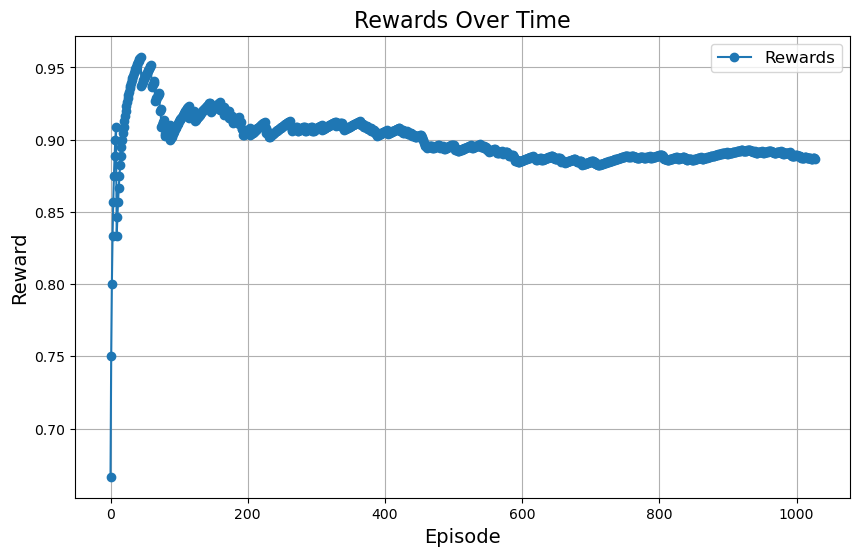

In [ ]:

import matplotlib.pyplot as plt

# Assuming env.visualization_manager.reward_list is a list of rewards
def plot_rewards(reward_list):
    plt.figure(figsize=(10, 6))
    plt.plot(reward_list, label="Rewards", marker='o', linestyle='-')
    plt.title("Rewards Over Time", fontsize=16)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Reward", fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()

# Example usage:
if hasattr(env, 'visualization_manager') and hasattr(env.visualization_manager, 'reward_list'):
    plot_rewards(env.visualization_manager.reward_list)
else:
    print("reward_list not found in env.visualization_manager.")

Reward column:
0      0.003295
1      0.003833
2      0.006500
3      0.006500
4      0.011043
         ...   
253    0.023206
254    0.023206
255    0.023206
256    0.023206
257    0.023206
Name: total_energy_consumption, Length: 258, dtype: float64


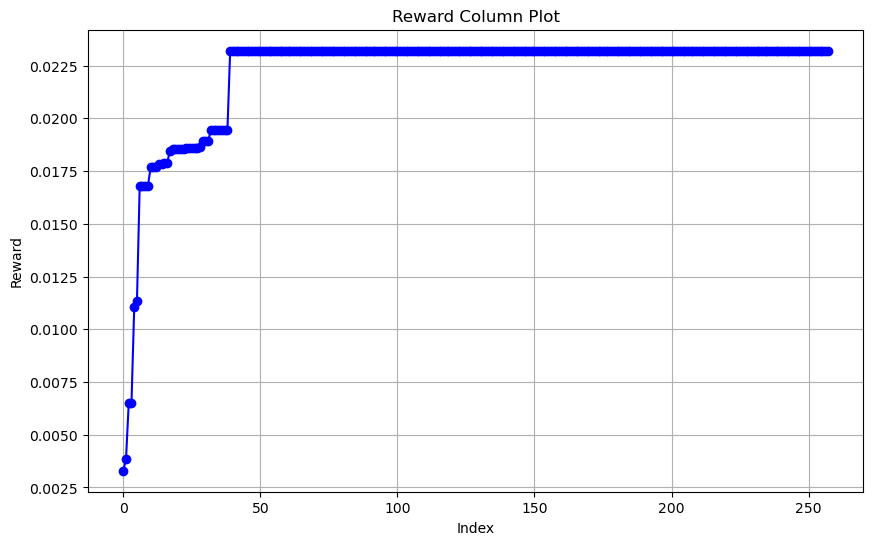

0      0.003295
1      0.003833
2      0.006500
3      0.006500
4      0.011043
         ...   
253    0.023206
254    0.023206
255    0.023206
256    0.023206
257    0.023206
Name: total_energy_consumption, Length: 258, dtype: float64

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def read_reward_column(csv_file_path):
    try:
        # Load the CSV file
        data = pd.read_csv(csv_file_path)

        # Check if 'reward' column exists
        if 'reward' in data.columns:
            # Read the 'reward' column
            reward_column = data['total_energy_consumption']
            print("Reward column:")
            print(reward_column)

            # Plot the reward column
            plt.figure(figsize=(10, 6))
            plt.plot(reward_column, marker='o', linestyle='-', color='b')
            plt.title('Reward Column Plot')
            plt.xlabel('Index')
            plt.ylabel('Reward')
            plt.grid(True)
            plt.show()

            return reward_column
        else:
            print("Error: 'reward' column not found in the CSV file.")
            return None
    except FileNotFoundError:
        print("Error: File not found. Please check the file path.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
csv_file_path = "results/reinforcement_learning.csv"  # Replace with your actual file path
read_reward_column(csv_file_path)